In [1]:
import sys
import os
import numpy as np
import pandas as pd
import pyranges as pr


In [3]:
#Read GTEx targets

targets_df = pd.read_csv('targets_gtex.txt', index_col=0, sep='\t')

#Get target strands
targets_strand = []

#Loop over target rows
for ti, identifier in enumerate(targets_df.identifier):
    if targets_df.index[ti] == targets_df.strand_pair.iloc[ti]:
        targets_strand.append('.')
    else:
        targets_strand.append(identifier[-1])

targets_df['strand'] = targets_strand

#Select only one strand
strand_mask = (targets_df.strand != '-')
targets_strand_df = targets_df[strand_mask]


In [4]:
#Store original target indices

targets_strand_df['row_index'] = np.arange(len(targets_strand_df), dtype='int32')


In [5]:
#Compile dictionary of tissue targets (with replicates)
tissues = sorted(targets_strand_df['description'].unique().tolist())
tissues = [tissue[4:] for tissue in tissues]

tissue_dict = {}

#Loop over target rows
for _, row in targets_strand_df.iterrows() :
    target_i = row['row_index']
    
    tissue = row['description'][4:]
    
    if tissue not in tissue_dict :
        tissue_dict[tissue] = []
    
    tissue_dict[tissue].append(target_i)


In [6]:
#Make 'other' tissues

#Loop over tissues
for tissue in tissues :
    tissue_targets = set(tissue_dict[tissue])
    
    other_targets = []
    
    #Loop over tissues (again)
    for other_tissue in tissues :
        other_tissue_targets = tissue_dict[other_tissue]
        
        #Add tissue if different from current tissue of interest
        if other_tissue != tissue :
            
            #Loop over output track indices of tissue
            for other_target_i in other_tissue_targets :
                if other_target_i not in tissue_targets :
                    other_targets.append(other_target_i)
    
    tissue_dict[tissue + '_other'] = other_targets

tissues = tissues + [tissue + '_other' for tissue in tissues]


In [7]:
#Estimate pseudo counts from first fold (for predictions and measurements)

#Pseudo count quantile
pseudo_qtl = 0.05

#Fold to compute pseudo count from
fold_ix = 0

df_pred = pd.read_csv("test_tss/f" + str(fold_ix) + "c0/testetssmax0/tss_preds_gencode.tsv.gz", sep='\t', compression='gzip')
df_pred = df_pred.rename(columns={'Unnamed: 0' : 'tss_id'})

df_true = pd.read_csv("test_tss/f" + str(fold_ix) + "c0/testetssmax0/tss_targets_gencode.tsv.gz", sep='\t', compression='gzip')
df_true = df_true.rename(columns={'Unnamed: 0' : 'tss_id'})

#Compute pseudo count by target
pseudo_cov_pred = np.zeros(targets_strand_df.shape[0], dtype='float32')
pseudo_cov_true = np.zeros(targets_strand_df.shape[0], dtype='float32')

target_to_local_index_dict = {}

#Loop over targets
for ii, [_, row] in enumerate(targets_strand_df.iterrows()) :
    target_i = row['row_index']
    
    #Compute pseudo count from chosen target quantile (non-zero measured TSSs only)
    nonzero_index = np.nonzero(df_true[str(target_i)].values != 0.)[0]
    
    pseudo_cov_pred[ii] = np.quantile(df_pred.iloc[nonzero_index][str(target_i)].values, q=pseudo_qtl)
    pseudo_cov_true[ii] = np.quantile(df_true.iloc[nonzero_index][str(target_i)].values, q=pseudo_qtl)
    
    target_to_local_index_dict[target_i] = ii


In [8]:
#Load TSS dataframe

tss_df = pd.read_csv('/home/drk/common/data/genomes/hg38/genes/gencode41/gencode41_basic_tss2.bed', sep='\t', names=['chrom', 'start', 'end', 'tss_id', 'feat1', 'tss_strand'])


In [9]:
#Load and augment measured / predicted coverages to tss dataframe

fold_index = [0, 1, 2, 3]

cov_pred_dict = {}
cov_true_dict = {}
cov_pred_dict_test = {}
cov_true_dict_test = {}
fold_dict = {}

#Loop over train / valid / test splits
for split_label in ['test'] :
    
    print("--- split_label = " + str(split_label) + " ---")

    #Loop over folds
    for fold_ix in fold_index :

        print("Processing fold = " + str(fold_ix))

        #Load predictions
        df_pred = pd.read_csv("test_tss/f" + str(fold_ix) + "c0/" + split_label + "etssmax0/tss_preds_gencode.tsv.gz", sep='\t', compression='gzip')
        df_pred = df_pred.rename(columns={'Unnamed: 0' : 'tss_id'})

        #Load targets
        df_true = pd.read_csv("test_tss/f" + str(fold_ix) + "c0/" + split_label + "etssmax0/tss_targets_gencode.tsv.gz", sep='\t', compression='gzip')
        df_true = df_true.rename(columns={'Unnamed: 0' : 'tss_id'})

        #Aggregate average coverages for tissue replicates
        drop_columns = []

        #Loop over tissues
        for tissue in tissues :
            df_pred[tissue + '_pred'] = 0.
            df_true[tissue + '_true'] = 0.

            #Loop over output track indices
            for tissue_i in tissue_dict[tissue] :
                df_pred[tissue + '_pred'] += (df_pred[str(tissue_i)] + pseudo_cov_pred[target_to_local_index_dict[tissue_i]])
                df_true[tissue + '_true'] += (df_true[str(tissue_i)] + pseudo_cov_true[target_to_local_index_dict[tissue_i]])

                drop_columns.append(str(tissue_i))

            df_pred[tissue + '_pred'] /= len(tissue_dict[tissue])
            df_true[tissue + '_true'] /= len(tissue_dict[tissue])

        df_pred = df_pred.drop(columns=drop_columns).copy().reset_index(drop=True)
        df_true = df_true.drop(columns=drop_columns).copy().reset_index(drop=True)

        #Accumulate in pred dictionary (ensemble)
        for _, row in df_pred.iterrows() :
            if row['tss_id'] not in cov_pred_dict :
                cov_pred_dict[row['tss_id']] = {}

            #Loop over tissues
            for tissue in tissues :
                if tissue not in cov_pred_dict[row['tss_id']] :
                    cov_pred_dict[row['tss_id']][tissue] = 0.
                
                cov_pred_dict[row['tss_id']][tissue] += row[tissue + '_pred'] / float(len(fold_index))

        #Accumulate in true dictionary (ensemble)
        for _, row in df_true.iterrows() :
            if row['tss_id'] not in cov_true_dict :
                cov_true_dict[row['tss_id']] = {}

            #Loop over tissues
            for tissue in tissues :
                if tissue not in cov_true_dict[row['tss_id']] :
                    cov_true_dict[row['tss_id']][tissue] = 0.
                
                cov_true_dict[row['tss_id']][tissue] += row[tissue + '_true'] / float(len(fold_index))
        
        #Store test fold predicitons separately
        if split_label == 'test' :
        
            #Add onto pred dictionary (test fold only)
            for _, row in df_pred.iterrows() :
                if row['tss_id'] not in cov_pred_dict_test :
                    cov_pred_dict_test[row['tss_id']] = {}
                    fold_dict[row['tss_id']] = fold_ix

                    #Loop over tissues
                    for tissue in tissues :
                        cov_pred_dict_test[row['tss_id']][tissue] = row[tissue + '_pred']
                else :
                    print("[Warning] Duplicate test fold entries for tss_id = '" + str(row['tss_id']) + "' (pred)")
            
            #Add onto true dictionary (test fold only)
            for _, row in df_true.iterrows() :
                if row['tss_id'] not in cov_true_dict_test :
                    cov_true_dict_test[row['tss_id']] = {}

                    #Loop over tissues
                    for tissue in tissues :
                        cov_true_dict_test[row['tss_id']][tissue] = row[tissue + '_true']
                else :
                    print("[Warning] Duplicate test fold entries for tss_id = '" + str(row['tss_id']) + "' (true)")

print("len(cov_pred_dict) = " + str(len(cov_pred_dict)))
print("len(cov_true_dict) = " + str(len(cov_true_dict)))
print("len(cov_pred_dict_test) = " + str(len(cov_pred_dict_test)))
print("len(cov_true_dict_test) = " + str(len(cov_true_dict_test)))
print("len(fold_dict) = " + str(len(fold_dict)))


--- split_label = test ---
Processing fold = 0
Processing fold = 1
Processing fold = 2
Processing fold = 3
len(cov_pred_dict) = 55571
len(cov_true_dict) = 55571
len(cov_pred_dict_test) = 55571
len(cov_true_dict_test) = 55571
len(fold_dict) = 55571


In [10]:
#Append measurements and predictions from dictionaries to main tss dataframe

fold_strs = []

#Loop over TSSs
for _, row in tss_df.iterrows() :
    if row['tss_id'] in fold_dict :
        fold_strs.append('f' + str(fold_dict[row['tss_id']]))
    else :
        fold_strs.append(None)

tss_df['test_fold'] = fold_strs

#Loop over tissues
for tissue in tissues :
    pred_covs = []
    true_covs = []
    pred_covs_test = []
    true_covs_test = []
    
    #Loop over TSSs and assign train/test coverage values
    for _, row in tss_df.iterrows() :
        
        #Trained-on values
        if row['tss_id'] in cov_pred_dict :
            pred_covs.append(cov_pred_dict[row['tss_id']][tissue])
            true_covs.append(cov_true_dict[row['tss_id']][tissue])
        else :
            pred_covs.append(None)
            true_covs.append(None)
        
        #Held-out values
        if row['tss_id'] in cov_pred_dict_test :
            pred_covs_test.append(cov_pred_dict_test[row['tss_id']][tissue])
            true_covs_test.append(cov_true_dict_test[row['tss_id']][tissue])
        else :
            pred_covs_test.append(None)
            true_covs_test.append(None)
    
    tss_df[tissue + '_pred'] = pred_covs
    tss_df[tissue + '_true'] = true_covs
    
    tss_df[tissue + '_test_pred'] = pred_covs_test
    tss_df[tissue + '_test_true'] = true_covs_test

print("len(tss_df) = " + str(len(tss_df)))


len(tss_df) = 116649


In [11]:
#Get gene ids

tss_df['gene'] = tss_df['tss_id'].apply(lambda x: x.split("/")[1] if "/" in x else x)


In [12]:
#Save TSS dataframe with predictions and measurements

tss_df.to_csv('gencode41_basic_tss2_gtex_max_test.csv.gz', index=False, sep='\t', compression='gzip')


In [58]:
#(Re-)Load TSS dataframe

tss_df = pd.read_csv('gencode41_basic_tss2_gtex_max_test.csv.gz', sep='\t', compression='gzip')


/tmp/ipykernel_3764004/1860990085.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  tss_df = pd.read_csv('gencode41_basic_tss2_gtex_max_test.csv.gz', sep='\t', compression='gzip')


In [8]:
#Extract column names for Fantom5 data

col_names = []

#Open Fantom5 col name file
with open('/group/fdna/public/genomes/hg38/genes/fantom5/hg38_fair+new_CAGE_peaks_phase1and2_tpm.osc.txt', 'rt') as f :
    
    #Loop over rows
    for i, line in enumerate(f.readlines()) :
        if '##ColumnVariables[' in line[:100] :
            col_names.append(
                line.strip().split('Variables[')[1].split(']=')[0].replace('%20', ' ').replace('%2c', ',').replace('%2d', '-').replace('%2e', '.')
            )
        
        if i >= 2000 :
            break

col_names = ['fantom_id'] + col_names[1:]

print("len(col_names) = " + str(len(col_names)))


len(col_names) = 1830


In [9]:
#Load Fantom5 dataframes

fantom_df = pd.read_csv('/group/fdna/public/genomes/hg38/genes/fantom5/hg38_fair+new_CAGE_peaks_phase1and2.bed', names=['chrom', 'start', 'end', 'fantom_id', 'feat1', 'strand', 'tss_start', 'tss_end', 'feat2'], sep='\t')
fantom_counts_df = pd.read_csv('/group/fdna/public/genomes/hg38/genes/fantom5/hg38_fair+new_CAGE_peaks_phase1and2_tpm.osc.txt', names=col_names, skiprows=1834, sep='\t')


In [28]:
#Compute aggregated (sum) TPM per CAGE peak

agg_dict = {
    'all' : None,
    'blood' : 'blood',
    'muscle' : 'skeletal muscle',
    'brain' : 'brain',
    'liver': 'liver',
    'esophagus' : 'esophagus',
    'k562' : 'chronic myelogenous leukemia cell line%3aK562'
}

agg_cols = []

#Loop over aggregation lines
for agg_name in agg_dict :
    agg_str = agg_dict[agg_name]
    
    agg_col = 'tpm_sum' + ('_' + agg_name if agg_name != 'all' else '')
    agg_cols.append(agg_col)
    
    cols_to_agg = col_names[1:]
    if agg_str is not None :
        cols_to_agg = [col_name for col_i, col_name in enumerate(col_names) if agg_str in col_name]
    
    #Loop over rows in Fantom5 and aggregate matches
    tpm_sum = np.zeros(len(fantom_counts_df), dtype='float32')
    for col_name in cols_to_agg :
        tpm_sum += fantom_counts_df[col_name]

    fantom_counts_df[agg_col] = np.copy(tpm_sum)
    fantom_counts_df = fantom_counts_df.copy()

#Join onto CAGE peak dataframe
fantom_df = fantom_df.join(
    fantom_counts_df[['fantom_id'] + agg_cols].set_index('fantom_id'),
    on='fantom_id', how='inner'
).copy().reset_index(drop=True)

print("len(fantom_df) = " + str(len(fantom_df)))


len(fantom_df) = 209911


In [30]:
#Save intermediate Fantom5 dataframe

fantom_df.to_csv('Fantom5_CAGE_peaks_phase1and2_tpm_agg.csv.gz', index=False, sep='\t', compression='gzip')


In [59]:
#(Re-)Load Fantom5 dataframe

fantom_df = pd.read_csv('Fantom5_CAGE_peaks_phase1and2_tpm_agg.csv.gz', sep='\t', compression='gzip')


In [60]:
#Intersect against gencode TSS dataframe

padding_bp = 50

#Get TSS coordinates
tss_df['tss_start'] = tss_df['start'] + 1
tss_df['tss_end'] = tss_df['end'] + 1

#Subtract padding to get local intersect window
tss_df['start'] = tss_df['tss_start'] - padding_bp
tss_df['end'] = tss_df['tss_start'] + padding_bp
fantom_df['start'] = fantom_df['tss_start'] - padding_bp
fantom_df['end'] = fantom_df['tss_start'] + padding_bp

#Rename columns
tss_df = tss_df.rename(columns={'chrom' : 'Chromosome', 'start' : 'Start', 'end' : 'End', 'tss_strand' : 'Strand'})
fantom_df = fantom_df.rename(columns={'chrom' : 'Chromosome', 'start' : 'Start', 'end' : 'End', 'strand' : 'Strand'})

#Intersect dataframes
tss_pr = pr.PyRanges(tss_df)
fantom_pr = pr.PyRanges(fantom_df)

tss_fantom_pr = tss_pr.join(fantom_pr, strandedness='same')

tss_fantom_df = tss_fantom_pr.df.copy().reset_index(drop=True)
tss_fantom_df = tss_fantom_df.rename(columns={'Chromosome' : 'chrom', 'Start' : 'start', 'End' : 'end', 'Strand' : 'strand'})

#Aggregate over multiple Fantom IDs overlapping the same gencode TSS

agg_dict = {
    'chrom' : 'first',
    'gene' : 'first',
    'start' : 'first',
    'end' : 'first',
    'strand' : 'first',
    'test_fold' : 'first',
    'fantom_id' : 'first',
    'tss_start' : 'first',
    'tss_end' : 'first',
    'tpm_sum' : 'max',
    'tpm_sum_blood' : 'sum',
    'tpm_sum_muscle' : 'sum',
    'tpm_sum_brain' : 'sum',
    'tpm_sum_liver': 'sum',
    'tpm_sum_esophagus' : 'sum',
    'tpm_sum_k562' : 'sum',
}
for tissue in tissues :
    agg_dict[tissue + '_test_pred'] = 'first'
    agg_dict[tissue + '_test_true'] = 'first'

#Group and aggregate
tss_df = tss_fantom_df.groupby(['tss_id']).agg(agg_dict)
tss_df = tss_df.reset_index().copy()

#Sort rows
tss_df = tss_df.sort_values(by=['chrom', 'tss_start', 'tss_id']).copy().reset_index(drop=True)

print("len(tss_df) = " + str(len(tss_df)))


len(tss_df) = 63410


In [61]:
#Get TSS dataframe with coverage range coordinates

tss_range_df = tss_df[['chrom', 'start', 'end', 'tss_id', 'gene', 'strand', 'tss_start', 'tss_end']].copy().reset_index(drop=True)

tss_range_df.loc[tss_range_df['strand'] == '+', 'start'] = tss_range_df.loc[tss_range_df['strand'] == '+']['tss_end']
tss_range_df.loc[tss_range_df['strand'] == '+', 'end'] = tss_range_df.loc[tss_range_df['strand'] == '+']['tss_end'] + 128

tss_range_df.loc[tss_range_df['strand'] == '-', 'end'] = tss_range_df.loc[tss_range_df['strand'] == '-']['tss_start']
tss_range_df.loc[tss_range_df['strand'] == '-', 'start'] = tss_range_df.loc[tss_range_df['strand'] == '-']['tss_start'] - 128

tss_range_df = tss_range_df.rename(columns={'chrom' : 'Chromosome', 'start' : 'Start', 'end' : 'End', 'strand' : 'Strand'})


In [62]:
#Load gene span annotation with exons

gtf_file = '/home/drk/common/data/genomes/hg38/genes/gencode41/gencode41_basic_nort.gtf'

#Load gene span annotation
gtf_df = pd.read_csv(gtf_file, sep='\t', skiprows=5, names=['Chromosome', 'havana_str', 'feature', 'Start', 'End', 'feat1', 'Strand', 'feat2', 'id_str'])
gtf_df['gene_base'] = gtf_df['id_str'].apply(lambda x: x.split("gene_id \"")[1].split("\";")[0].split(".")[0])

#Filter for canonical transcript features only
gtf_df = gtf_df.query("havana_str == 'HAVANA'").copy().reset_index(drop=True)
gtf_df = gtf_df.loc[gtf_df['id_str'].str.contains("Ensembl_canonical")].copy().reset_index(drop=True)

#Exons only
gtf_df = gtf_df.query("feature == 'exon'").copy().reset_index(drop=True)

#Drop duplicate features
gtf_df = gtf_df.drop_duplicates(subset=['gene_base', 'feature', 'Start']).copy().reset_index(drop=True)

print("len(gtf_df) = " + str(len(gtf_df)))


len(gtf_df) = 276496


In [63]:
#Intersect against exon gtf annotation

tss_range_pr = pr.PyRanges(tss_range_df)
gtf_pr = pr.PyRanges(gtf_df)

tss_range_gtf_pr = tss_range_pr.join(gtf_pr, strandedness=None)
tss_range_gtf_df = tss_range_gtf_pr.df.copy().reset_index(drop=True)


In [64]:
#Categorize each TSS as overlapping an exon, or anti-sense-exon

tss_overlap_dict = {}
tss_antisense_overlap_dict = {}

#Loop over intersection rows
for _, row in tss_range_gtf_df.iterrows() :
    
    if row['Strand'] == row['Strand_b'] :
        tss_overlap_dict[row['tss_id']] = True
    elif row['Strand'] != row['Strand_b'] :
        tss_antisense_overlap_dict[row['tss_id']] = True

print("len(tss_overlap_dict) = " + str(len(tss_overlap_dict)))
print("len(tss_antisense_overlap_dict) = " + str(len(tss_antisense_overlap_dict)))


len(tss_overlap_dict) = 51290
len(tss_antisense_overlap_dict) = 2695


In [65]:
#Append exon overlap annotations to TSS dataframe

overlaps = []
antisense_overlaps = []

#Loop over TSS rows
for _, row in tss_df.iterrows() :
    if row['tss_id'] in tss_overlap_dict :
        overlaps.append(True)
    else :
        overlaps.append(False)
    
    if row['tss_id'] in tss_antisense_overlap_dict :
        antisense_overlaps.append(True)
    else :
        antisense_overlaps.append(False)

tss_df['exon_overlap'] = overlaps
tss_df['antisense_overlap'] = antisense_overlaps


In [66]:
#Save Fantom5-intersected TSS dataframe with predictions and measurements

tss_df.to_csv('gencode41_basic_tss2_gtex_max_test_w_fantom5.csv.gz', index=False, sep='\t', compression='gzip')


In [7]:
#(Re-)Load intersected TSS dataframe

tss_df = pd.read_csv('gencode41_basic_tss2_gtex_max_test_w_fantom5.csv.gz', sep='\t', compression='gzip')


Evaluating for fold = 0
spearman r = 0.889
p = 6.694881351640694e-185
n = 555
(pearson r = 0.884)


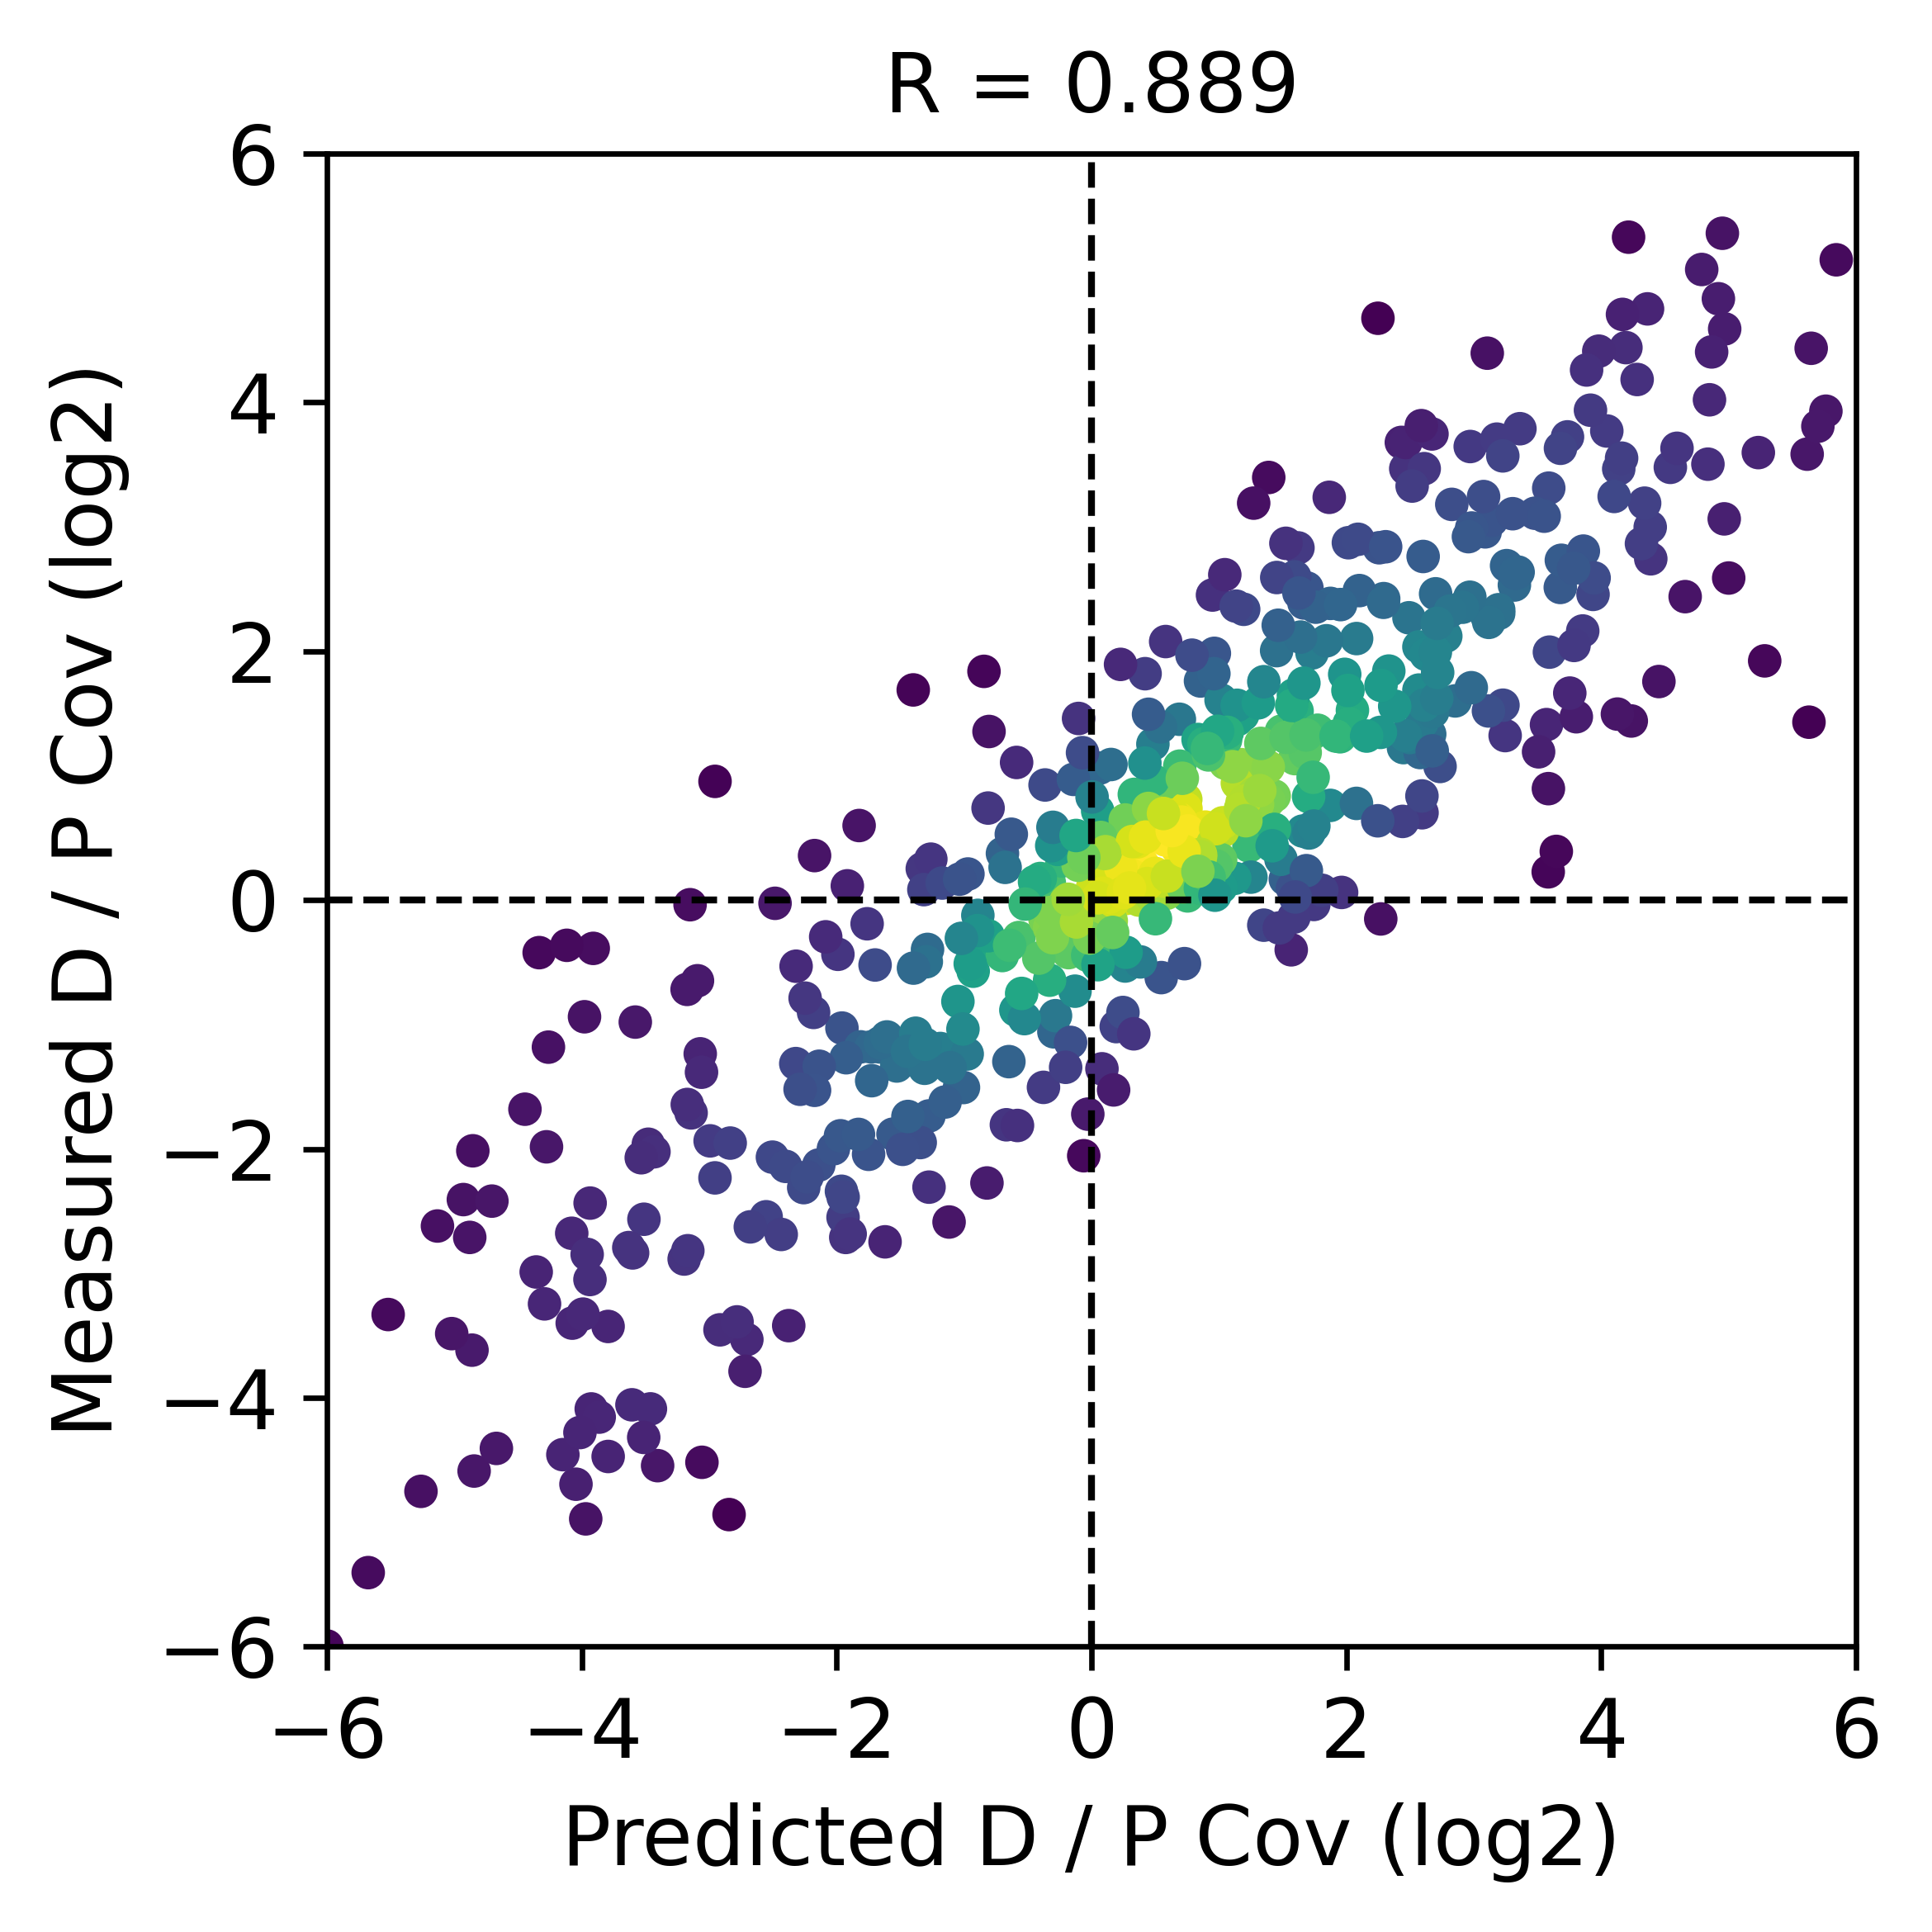

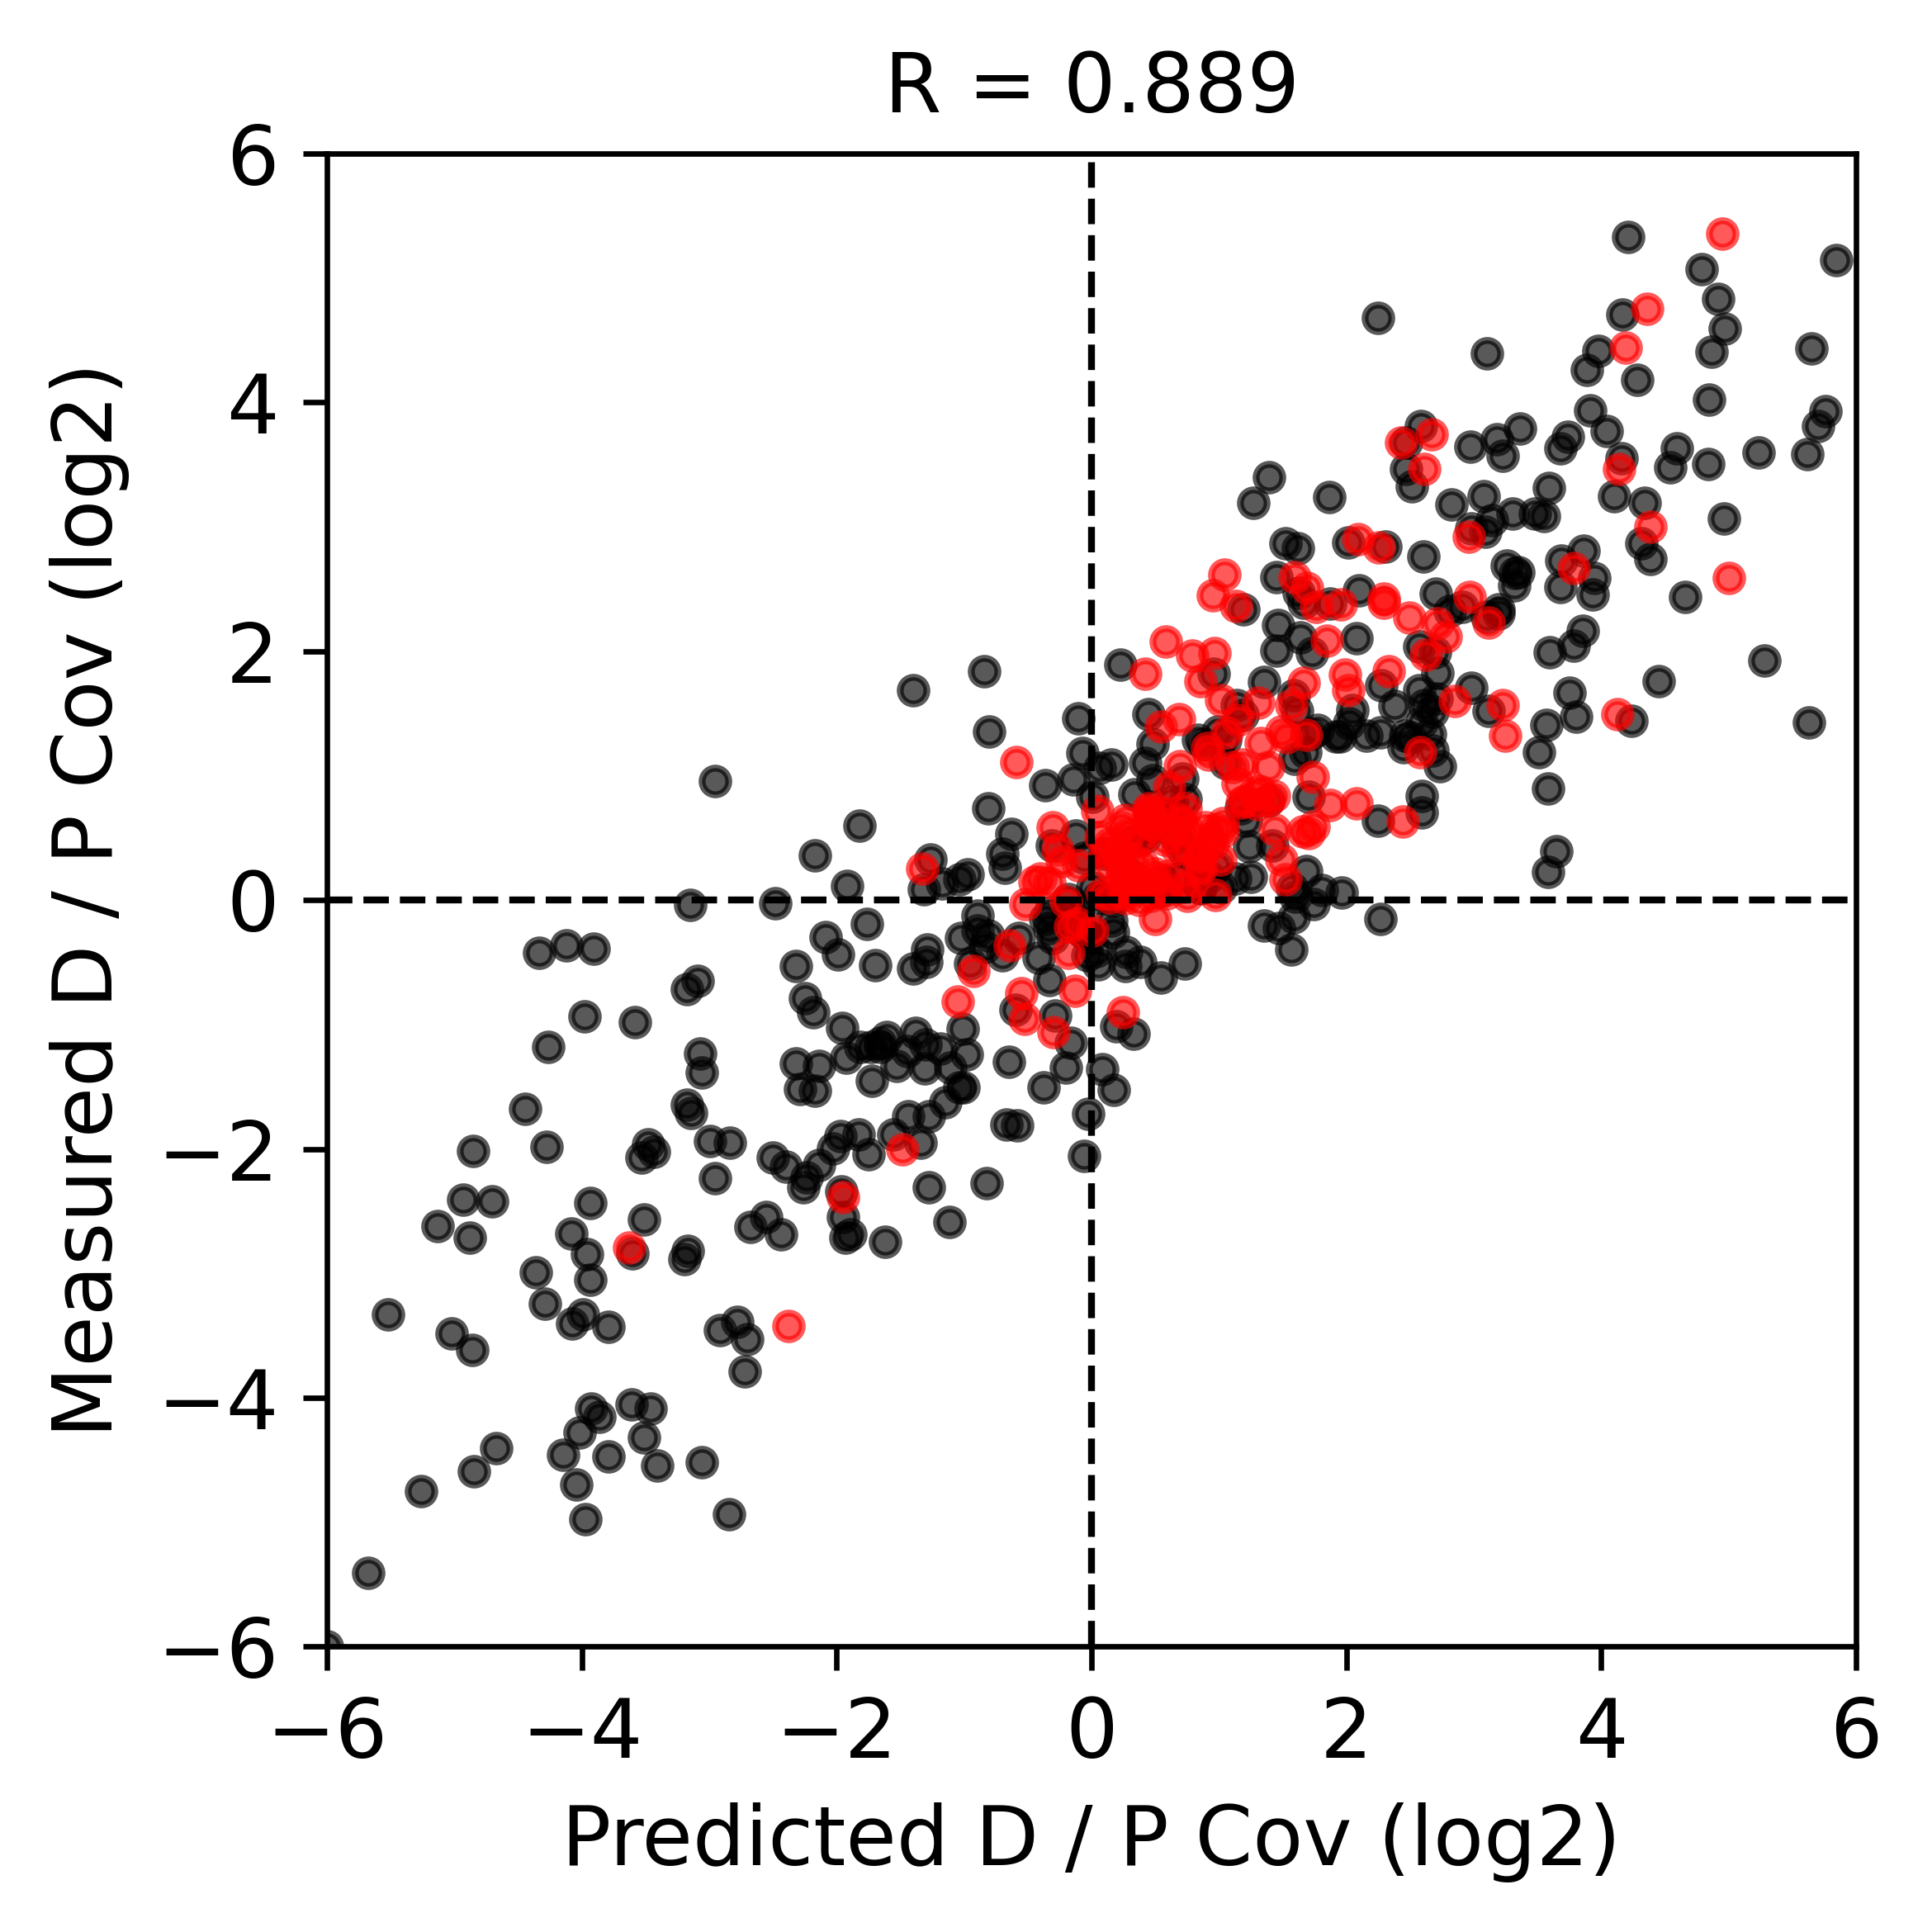

spearman r = 0.708
p = 1.999735819447301e-86
n = 555
(pearson r = 0.71)
spearman r = 0.639
p = 1.3811975161458022e-67
n = 555
(pearson r = 0.649)


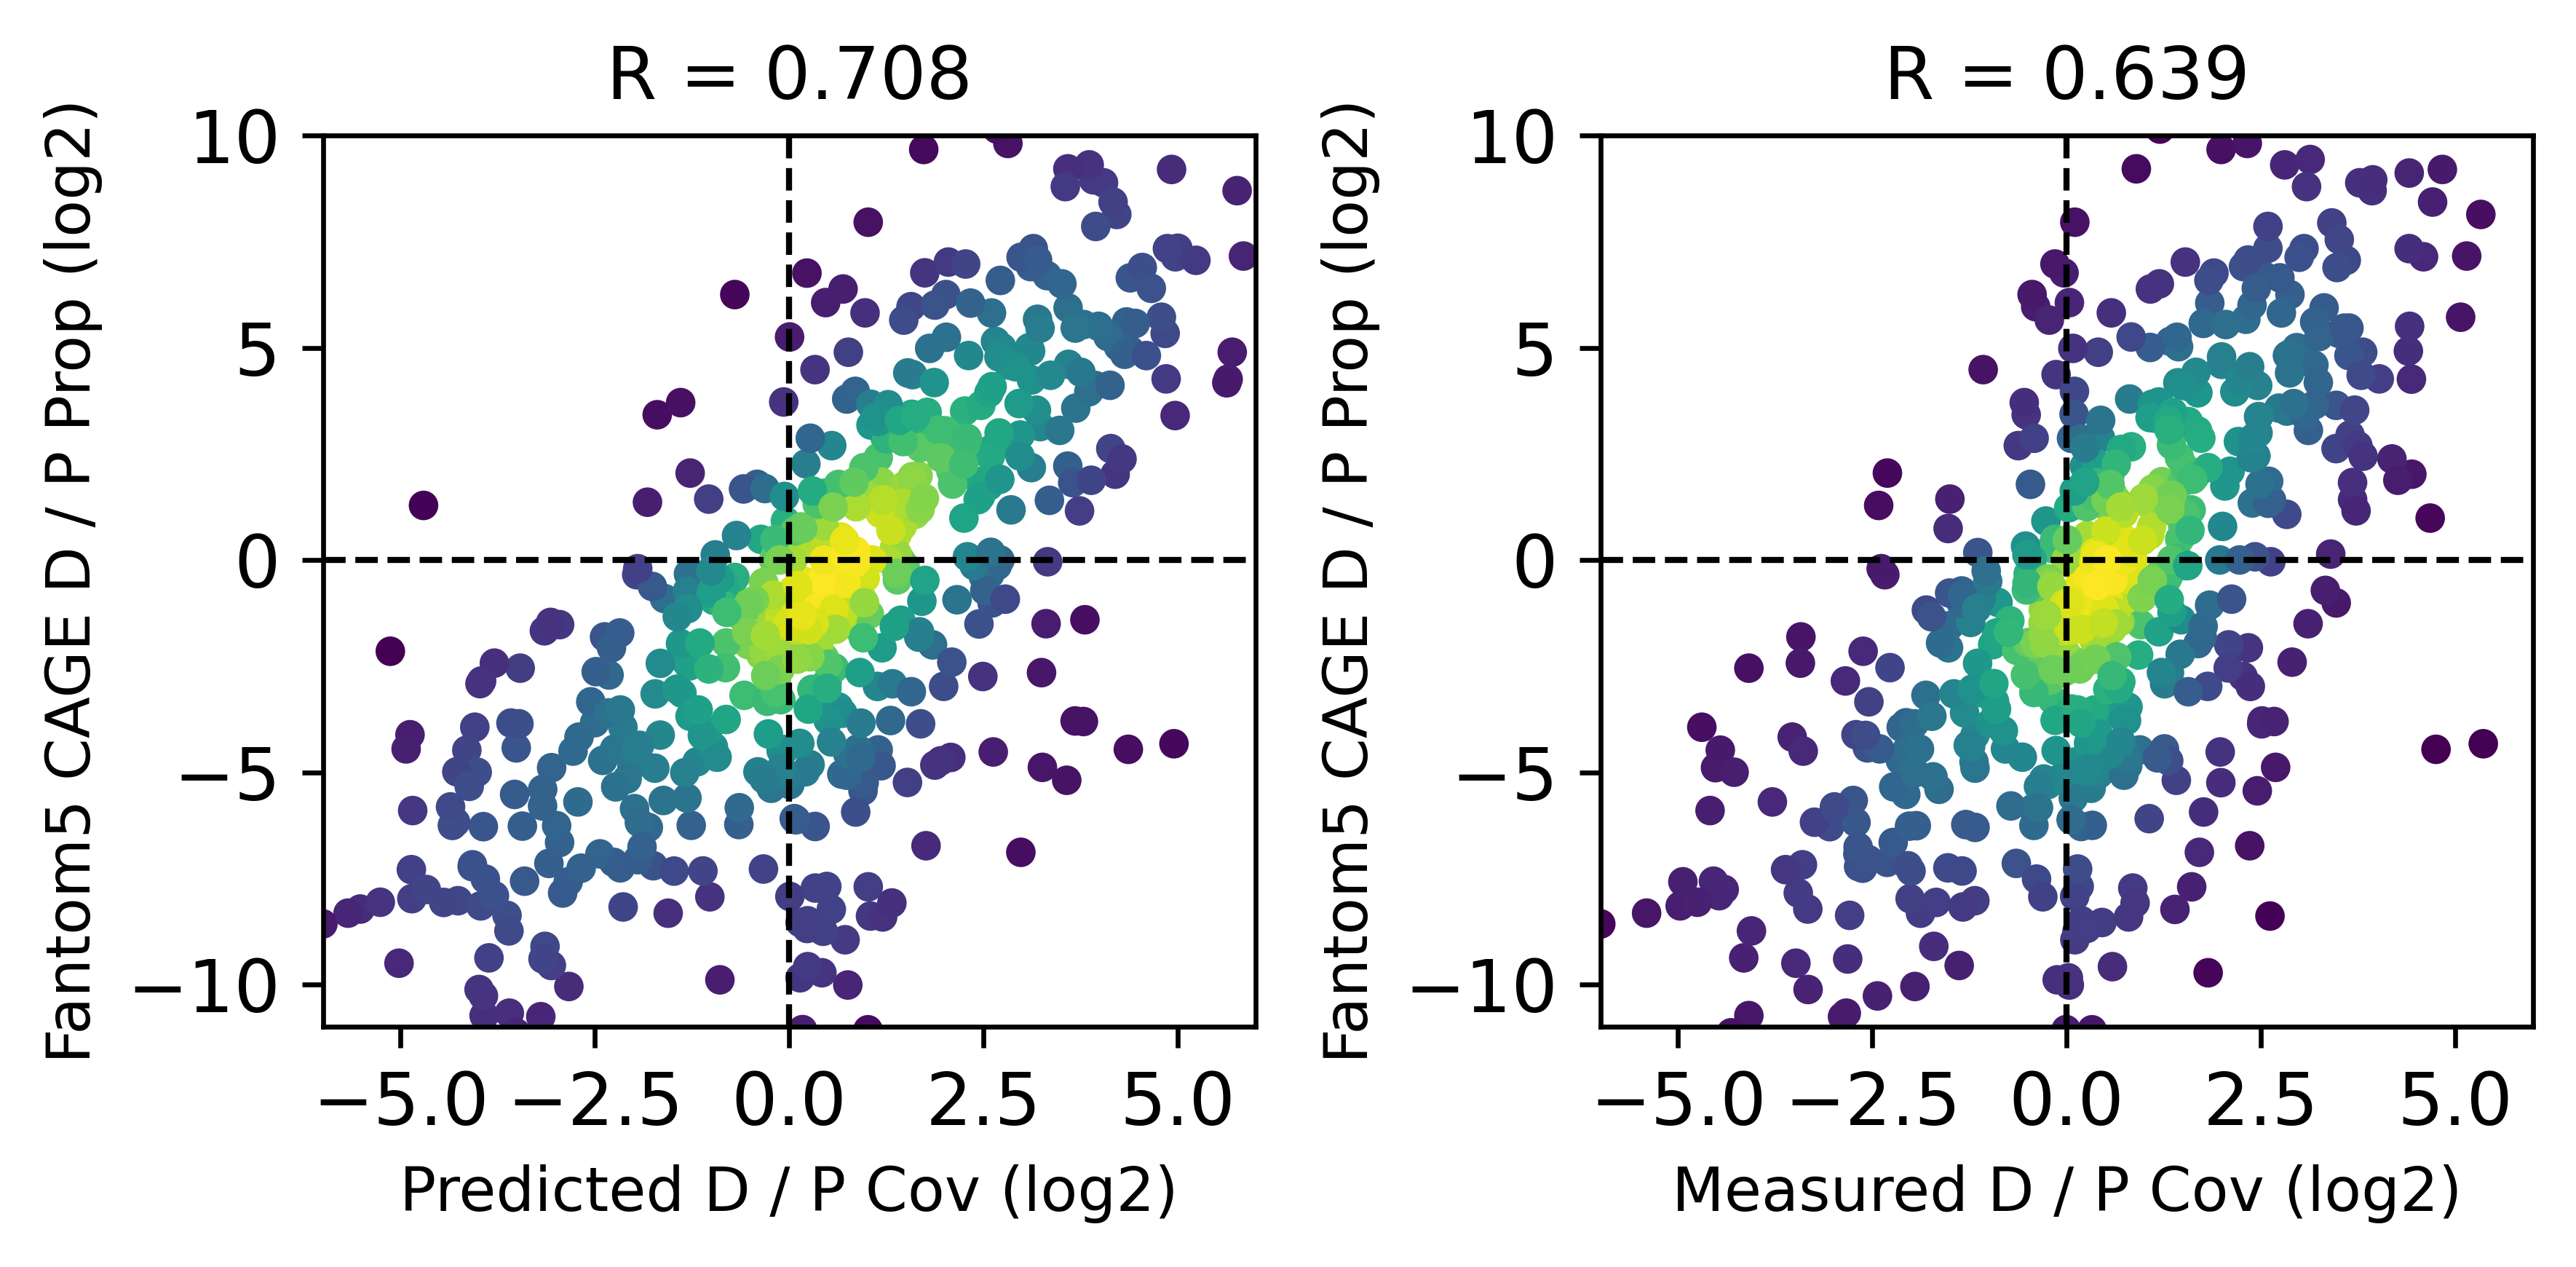

Evaluating for fold = 1
spearman r = 0.878
p = 1.1289773264462364e-226
n = 658
(pearson r = 0.891)


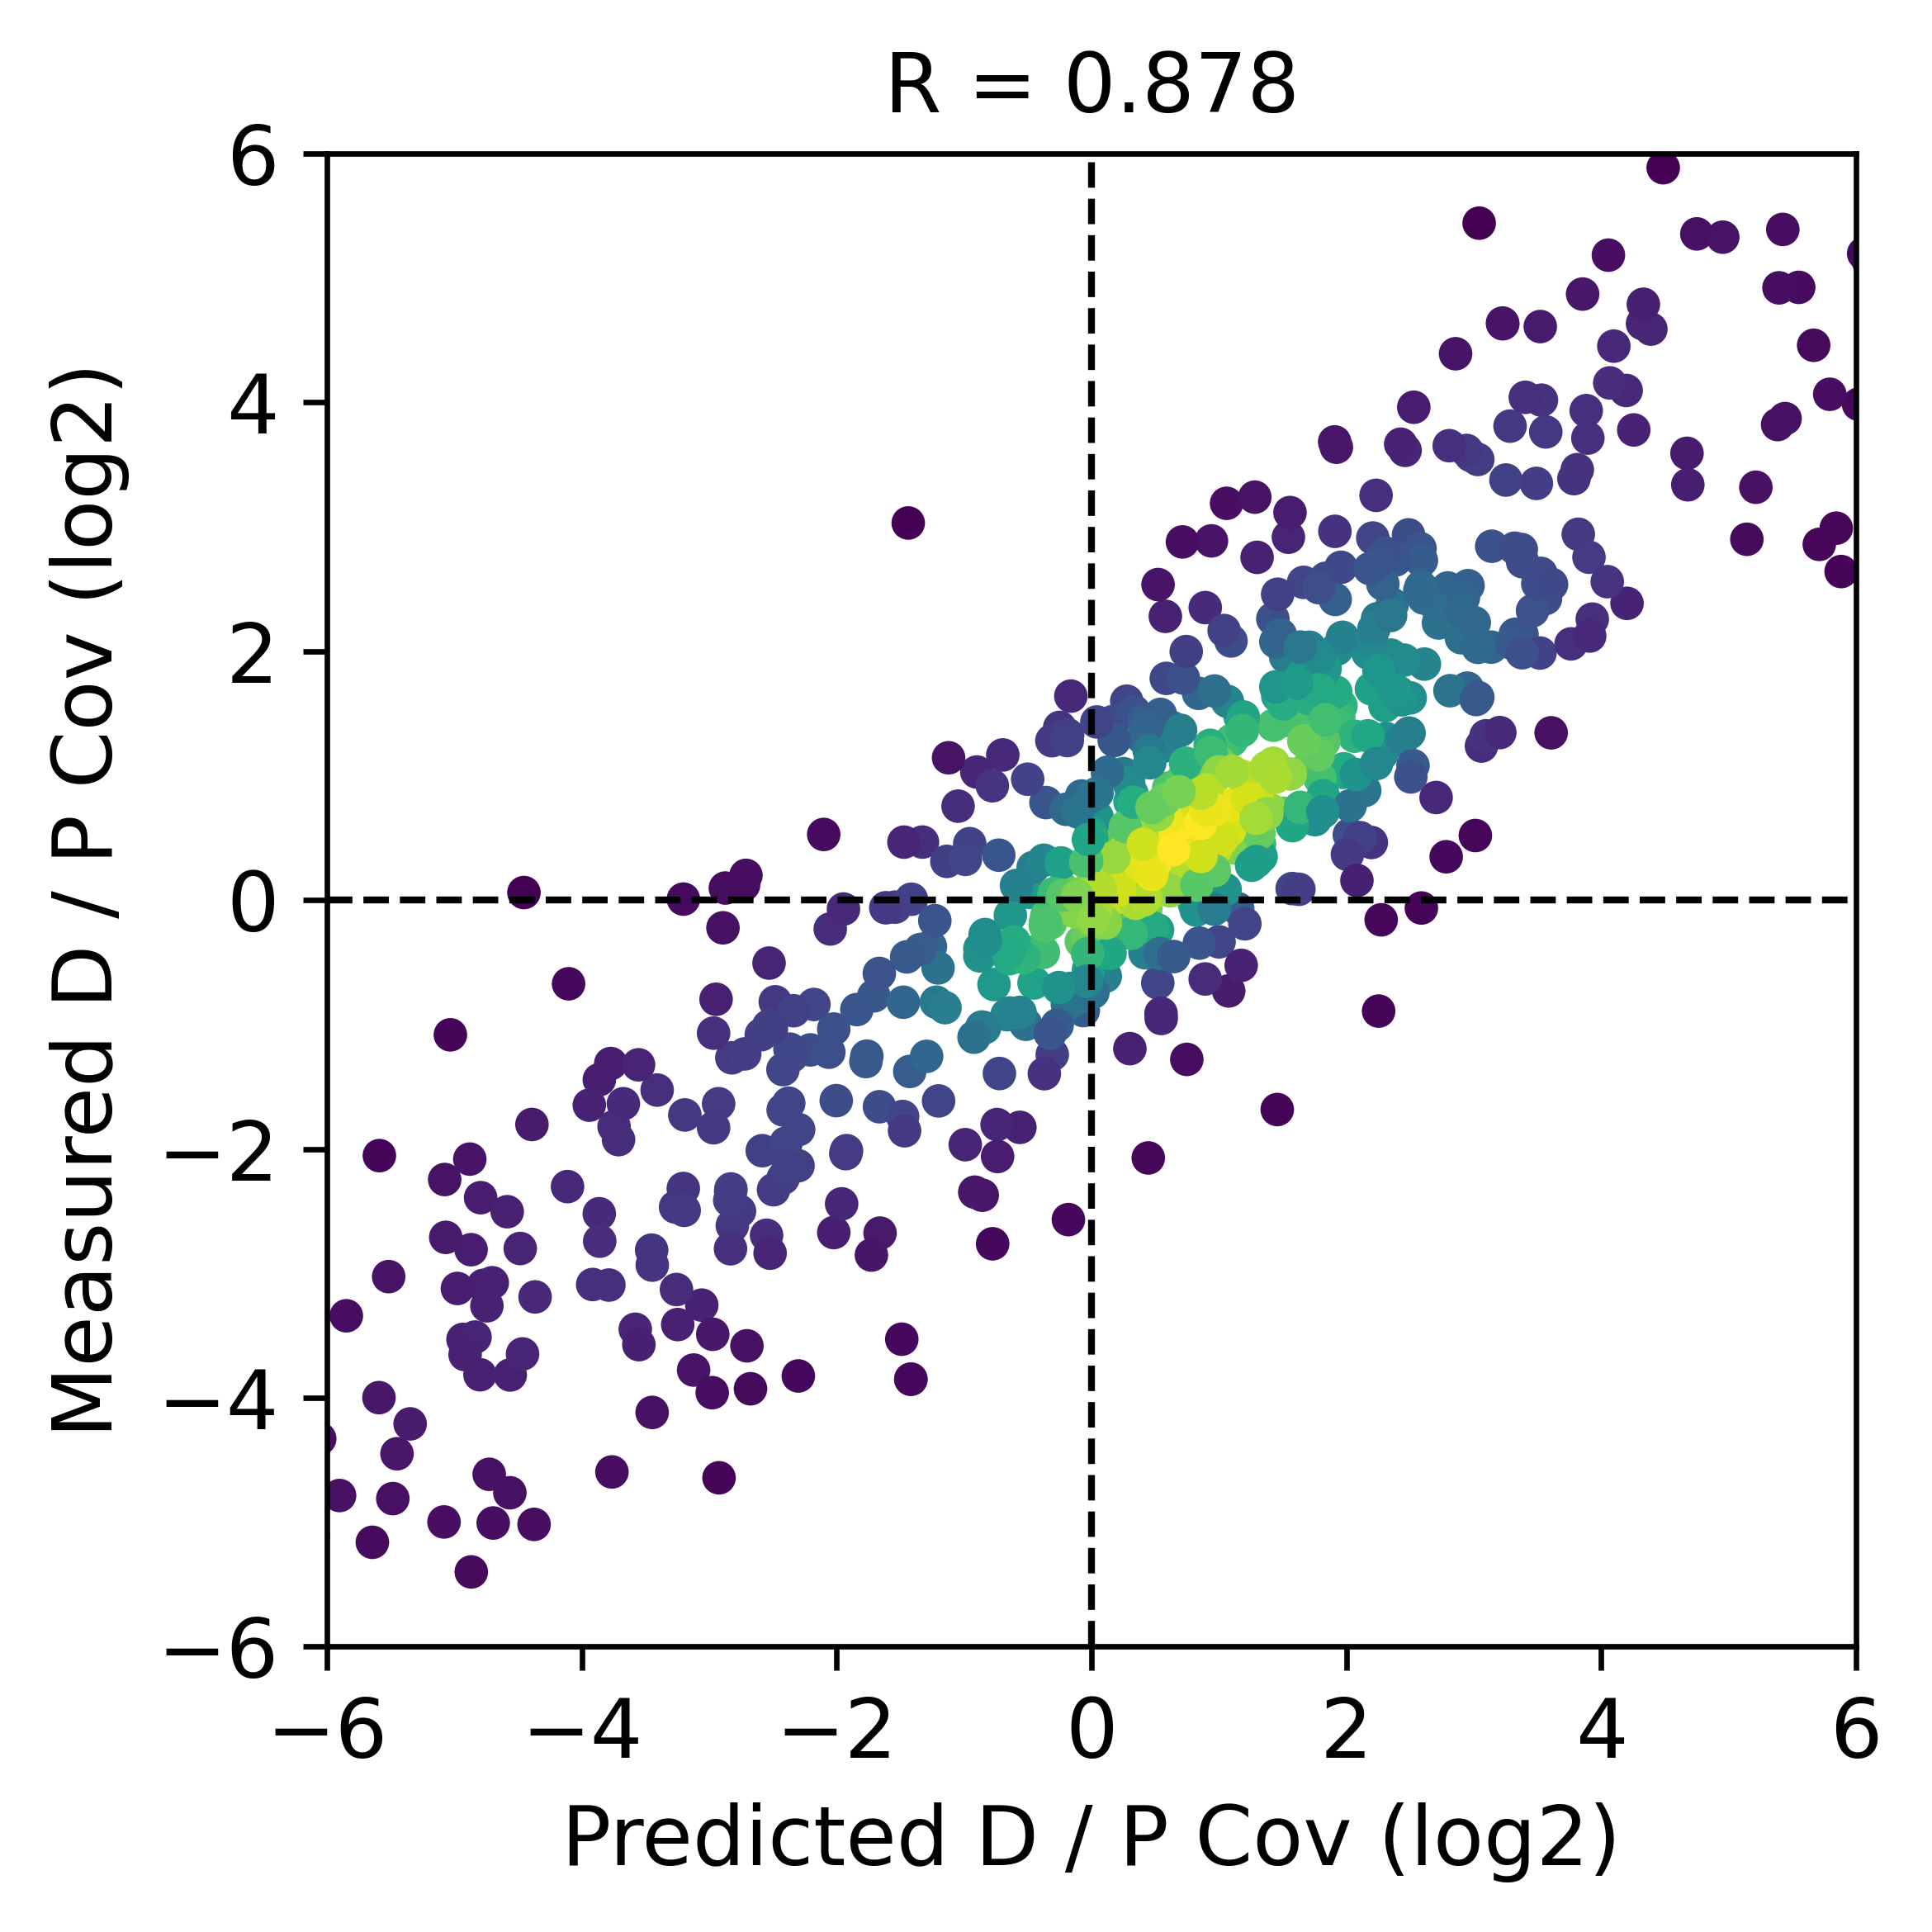

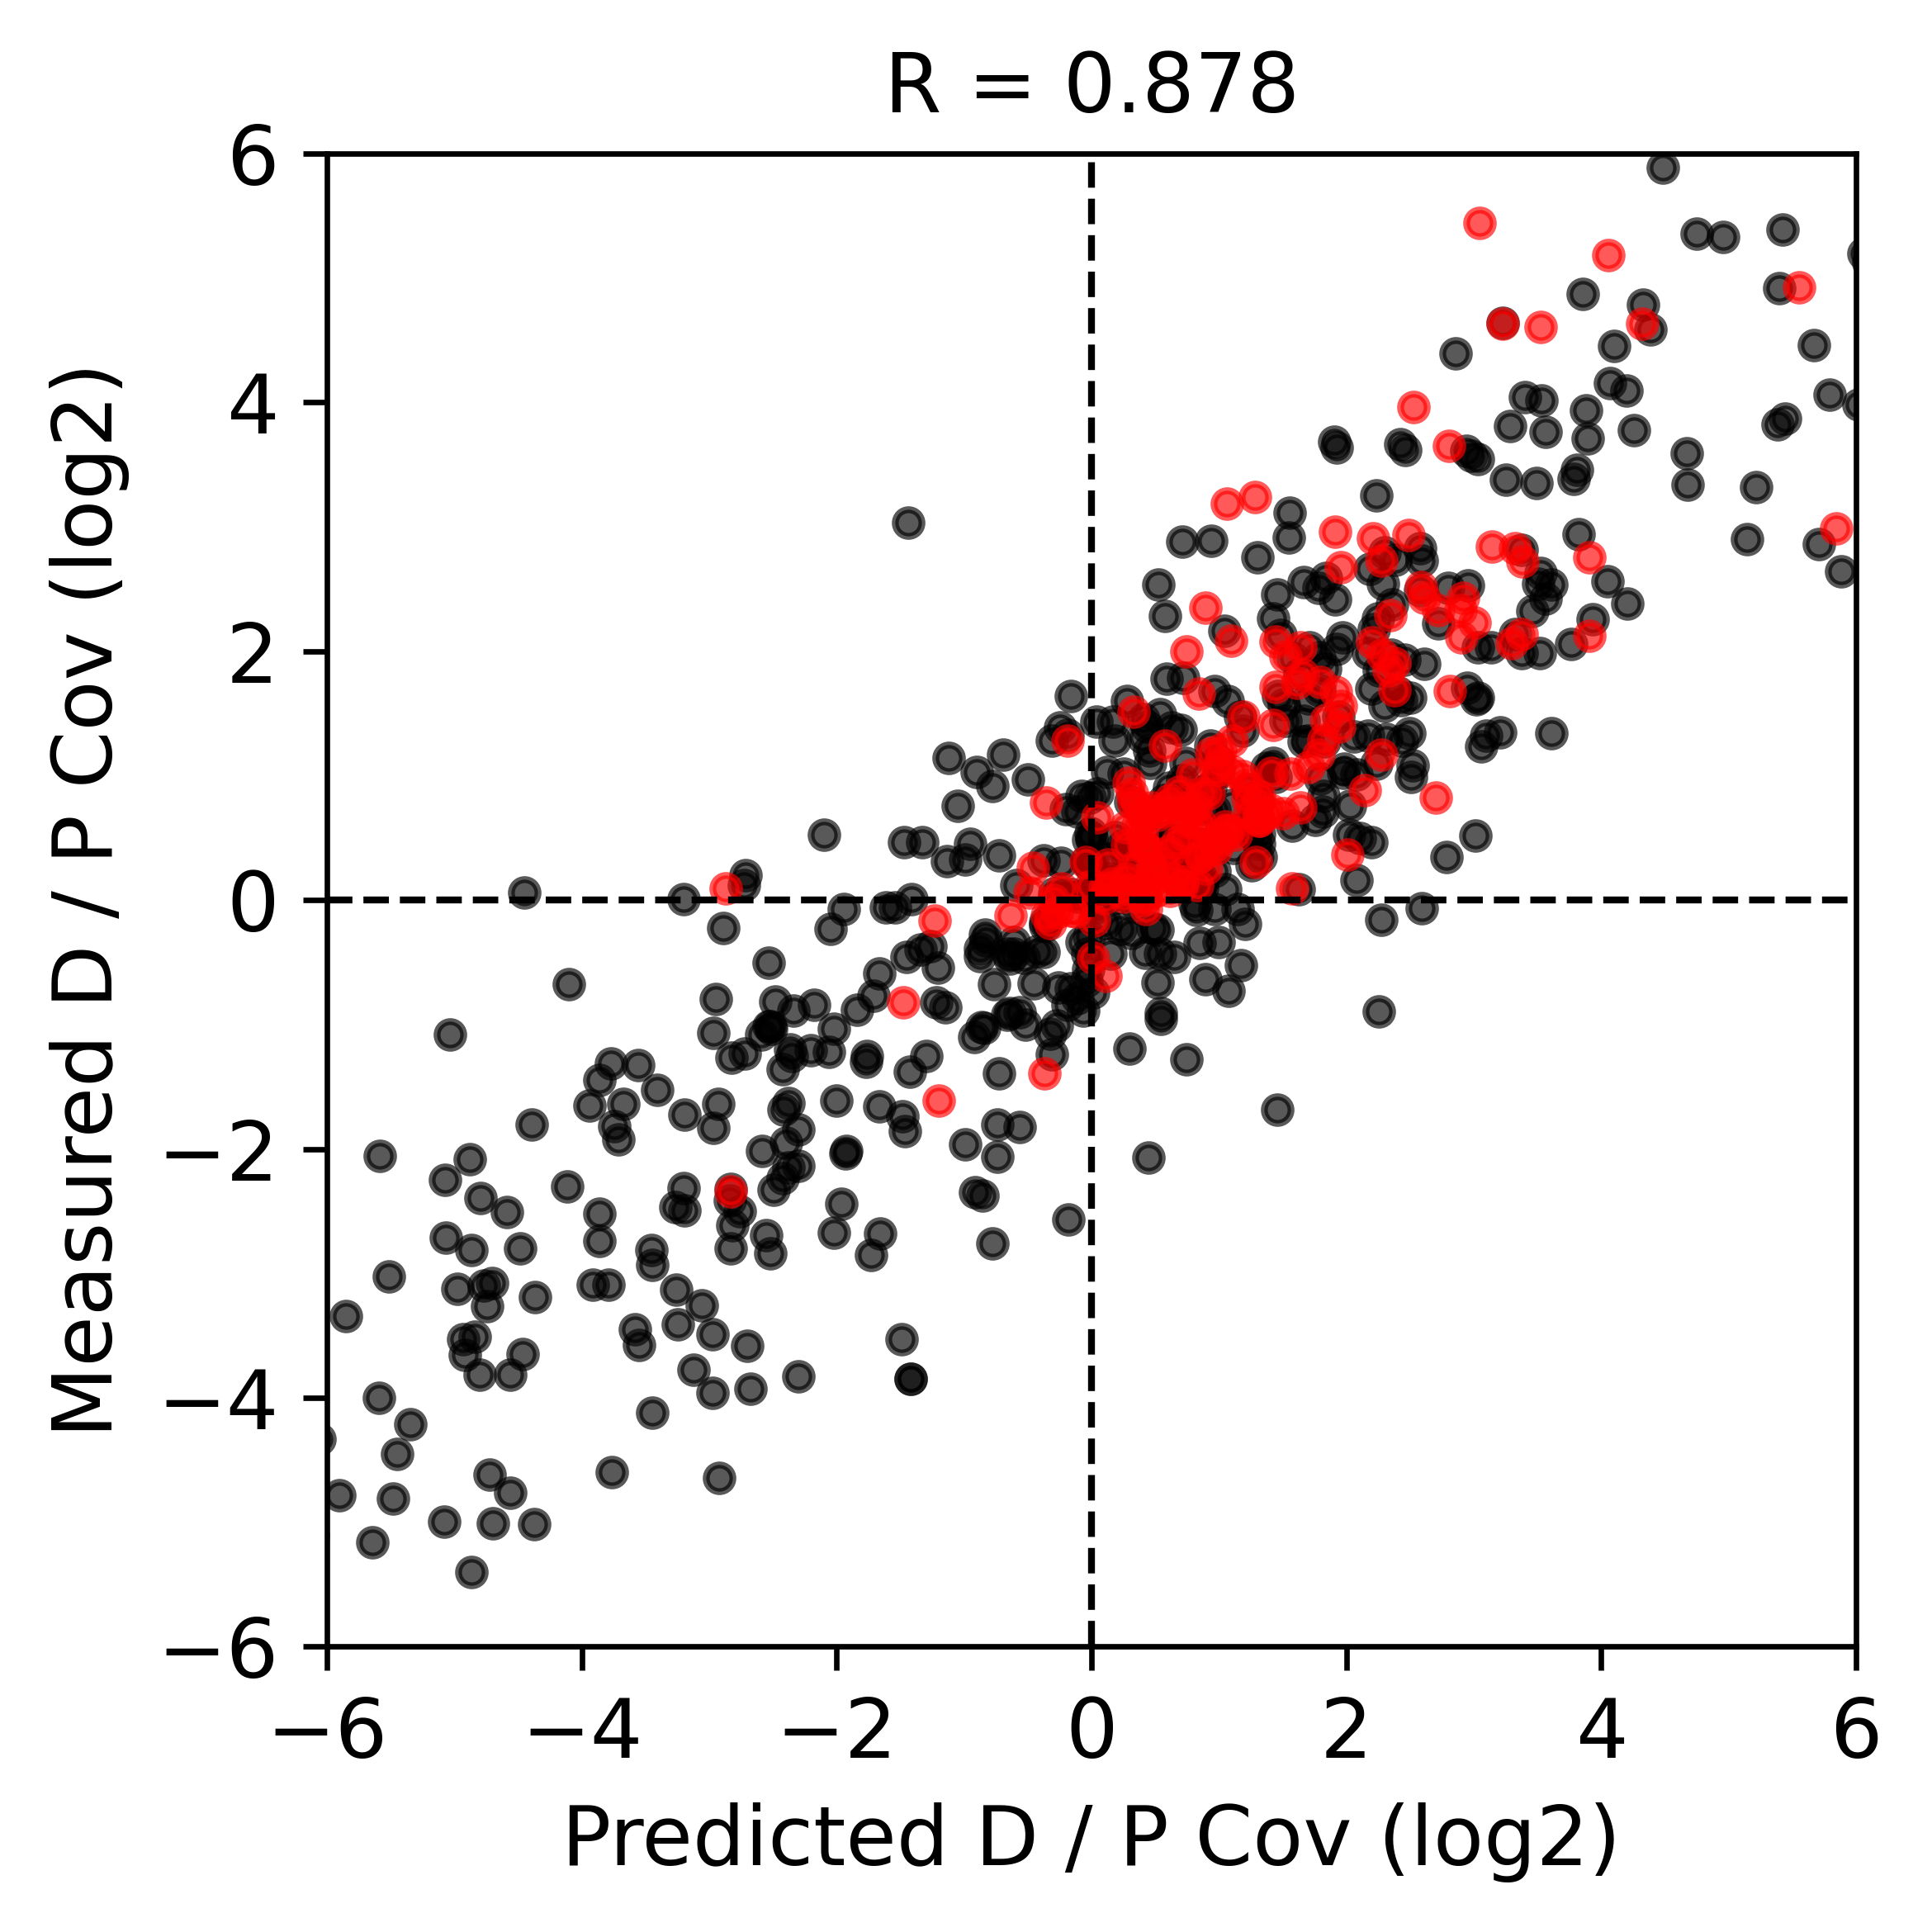

spearman r = 0.657
p = 1.6787994339695034e-94
n = 658
(pearson r = 0.691)
spearman r = 0.598
p = 8.882602988321622e-75
n = 658
(pearson r = 0.632)


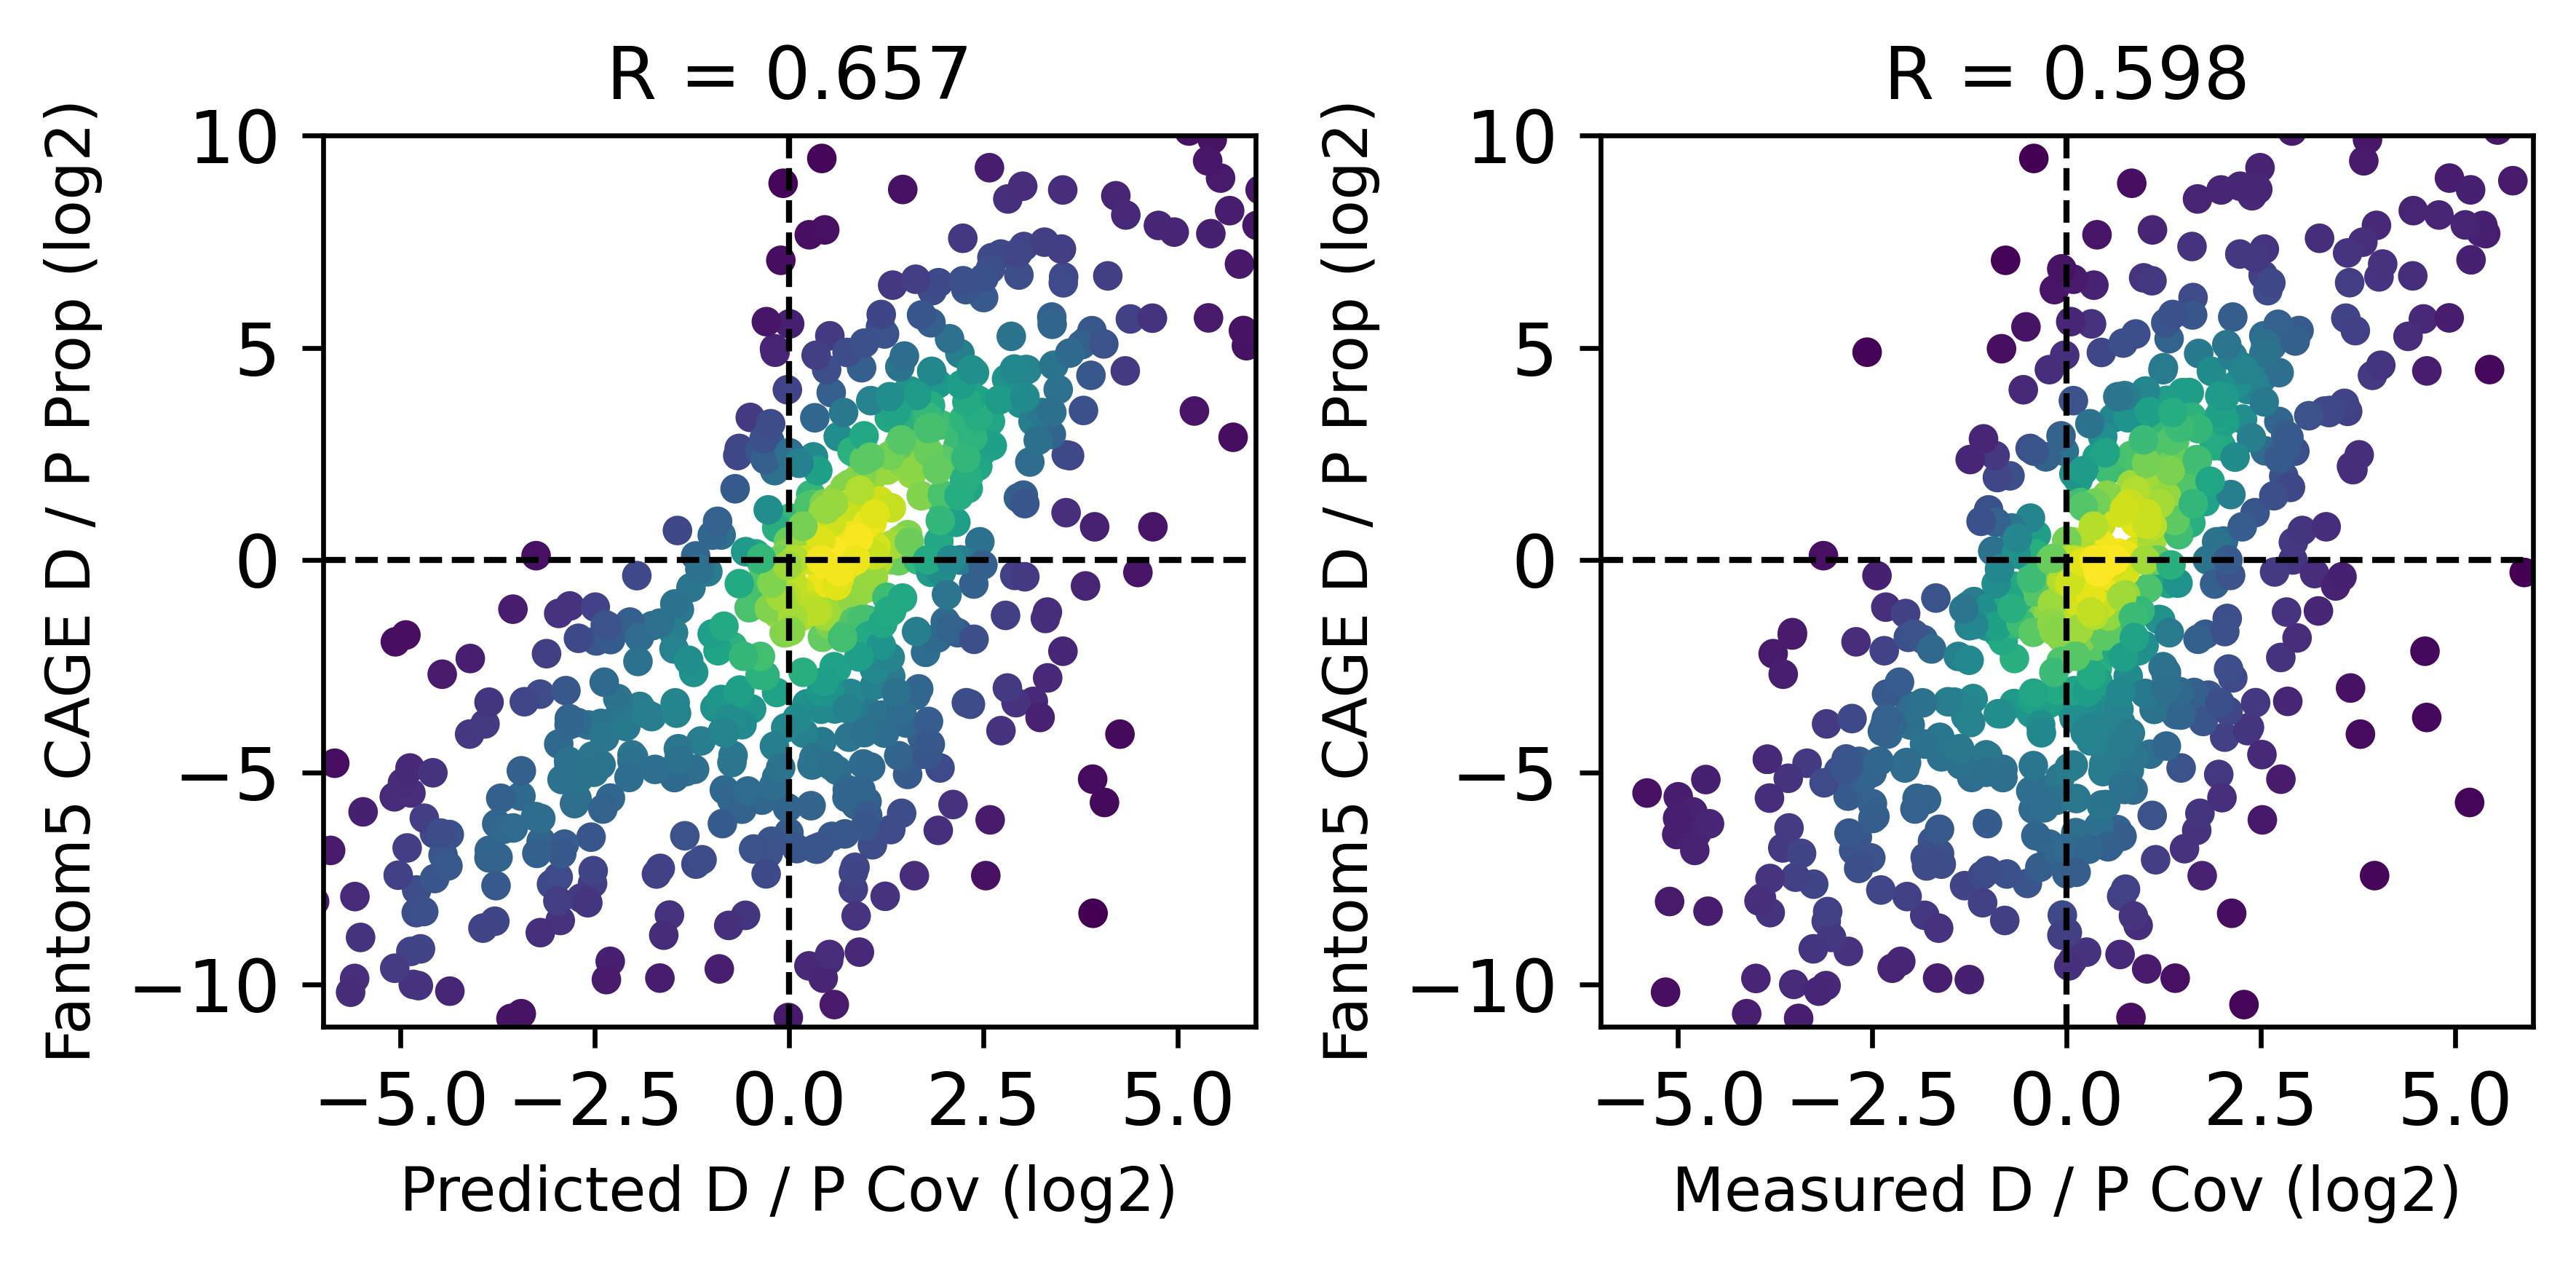

Evaluating for fold = 2
spearman r = 0.874
p = 5.173624537674674e-138
n = 442
(pearson r = 0.871)


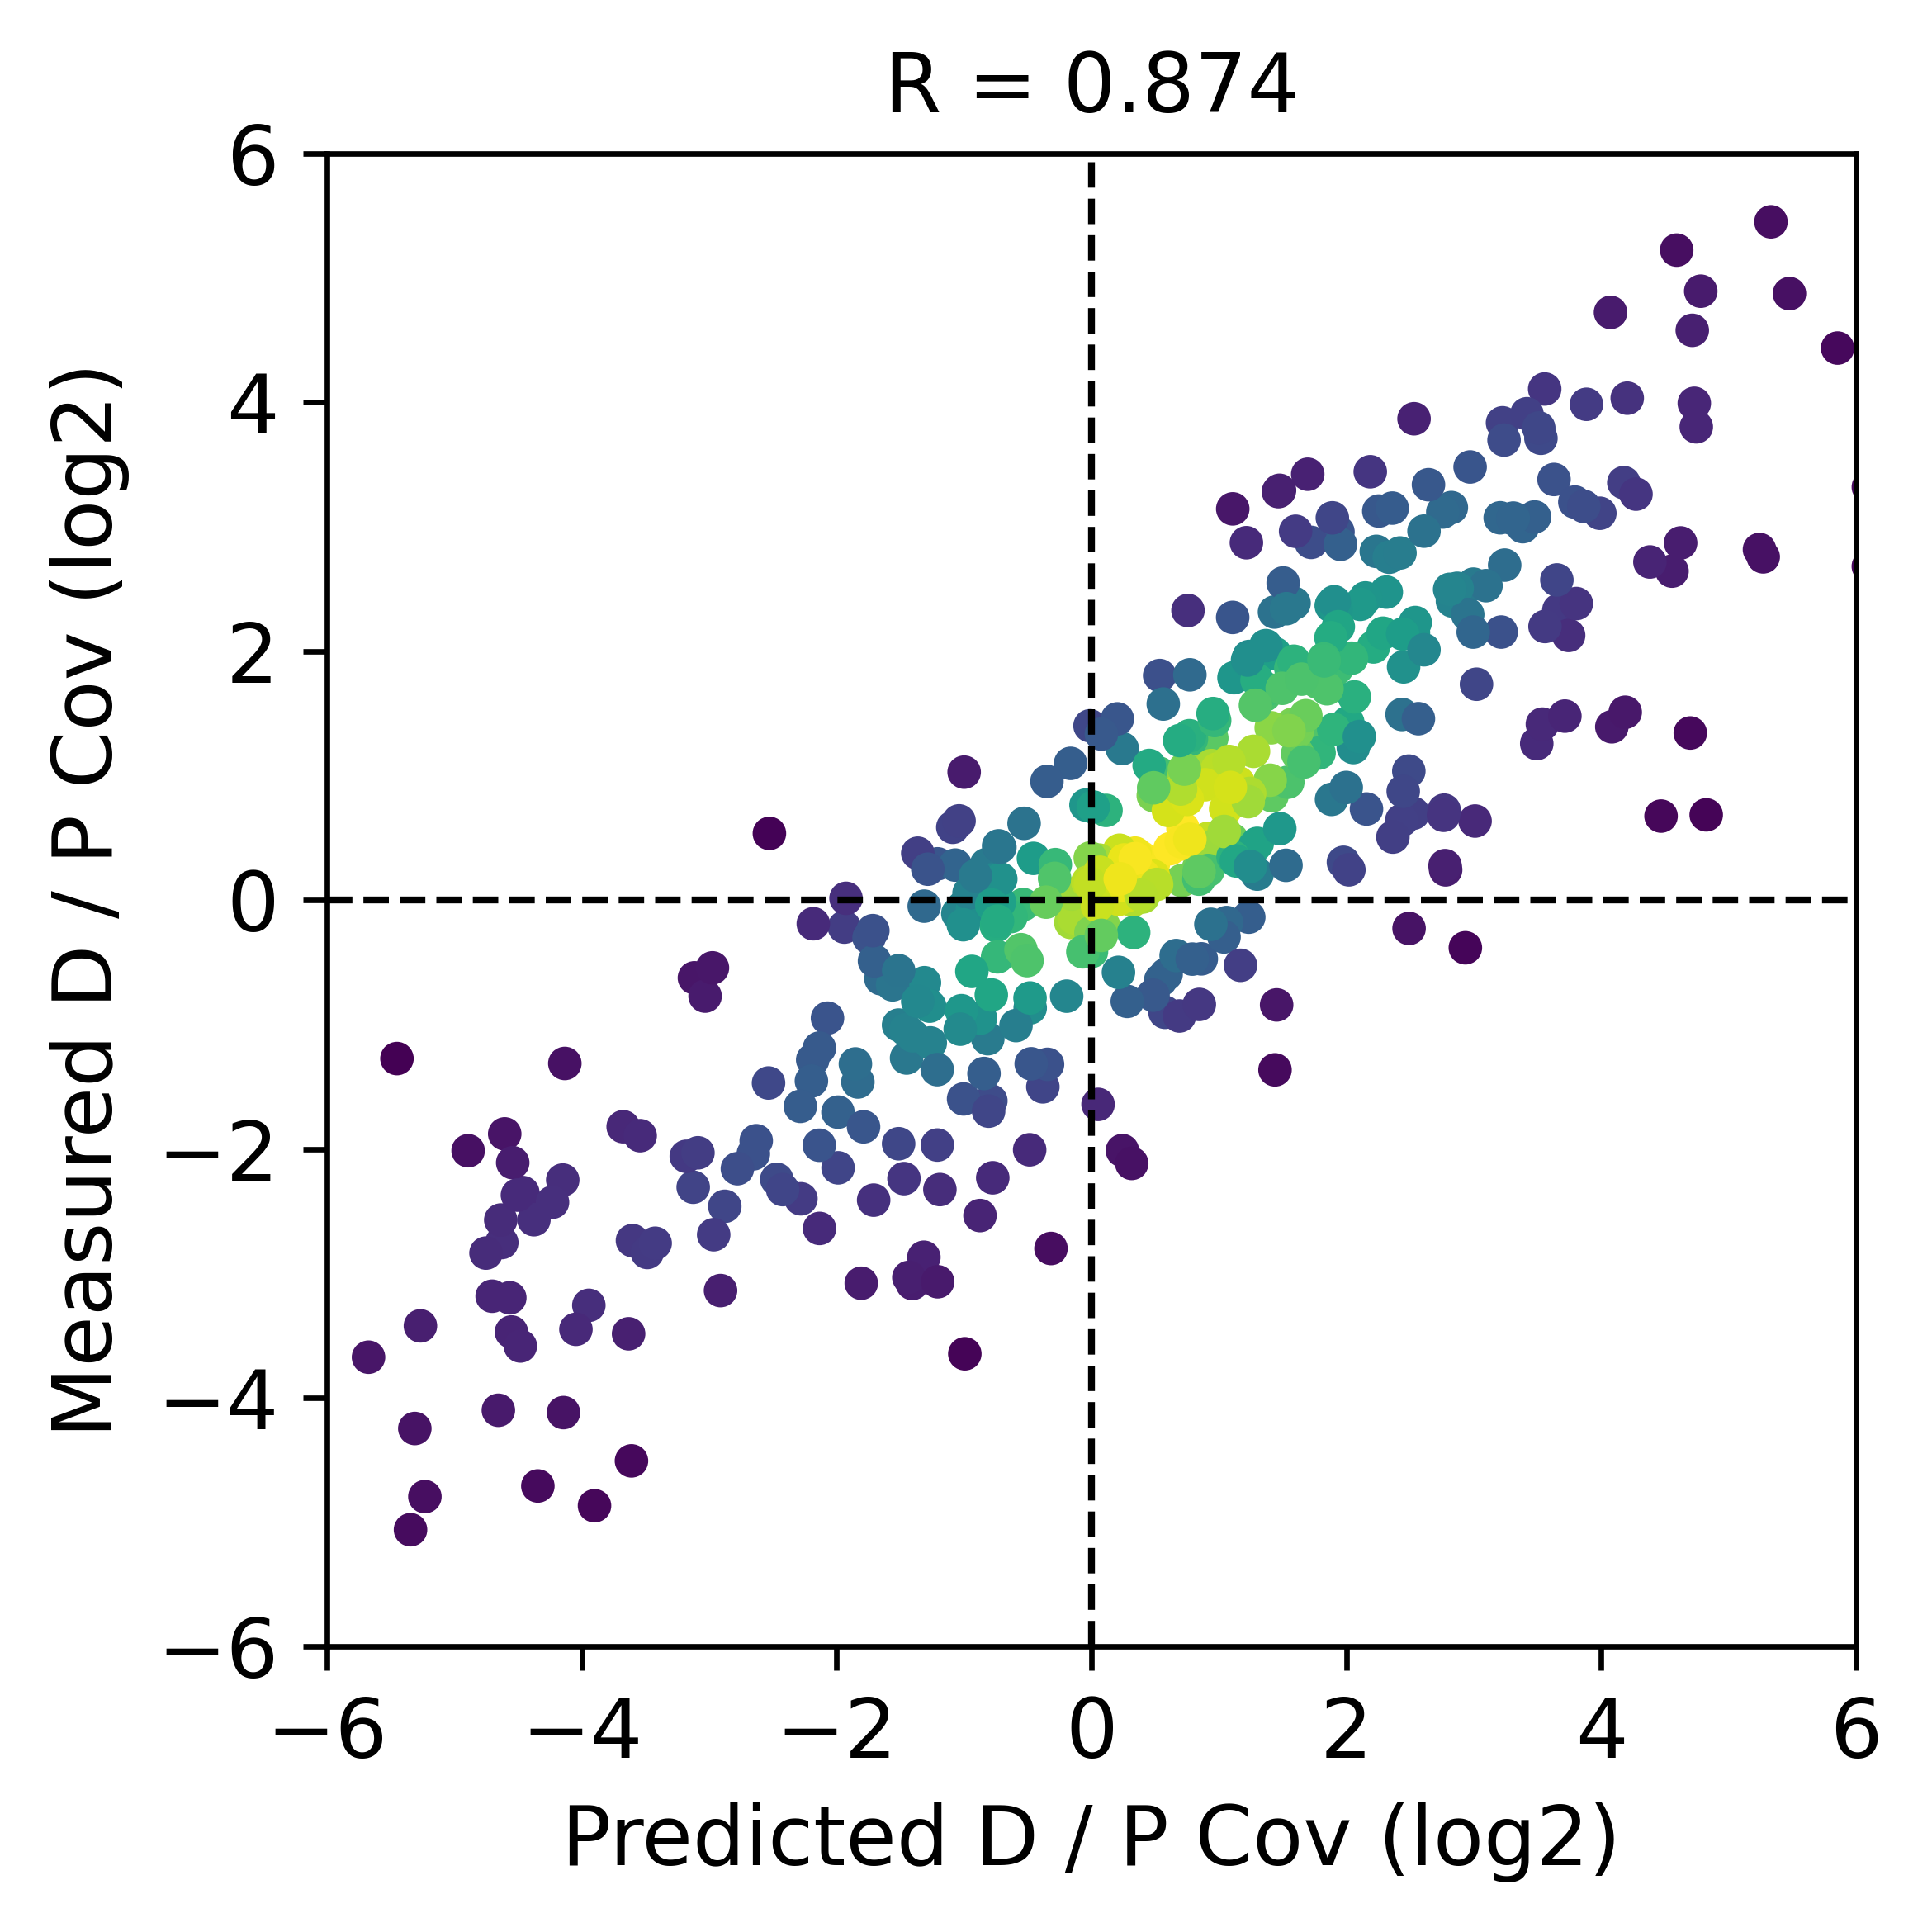

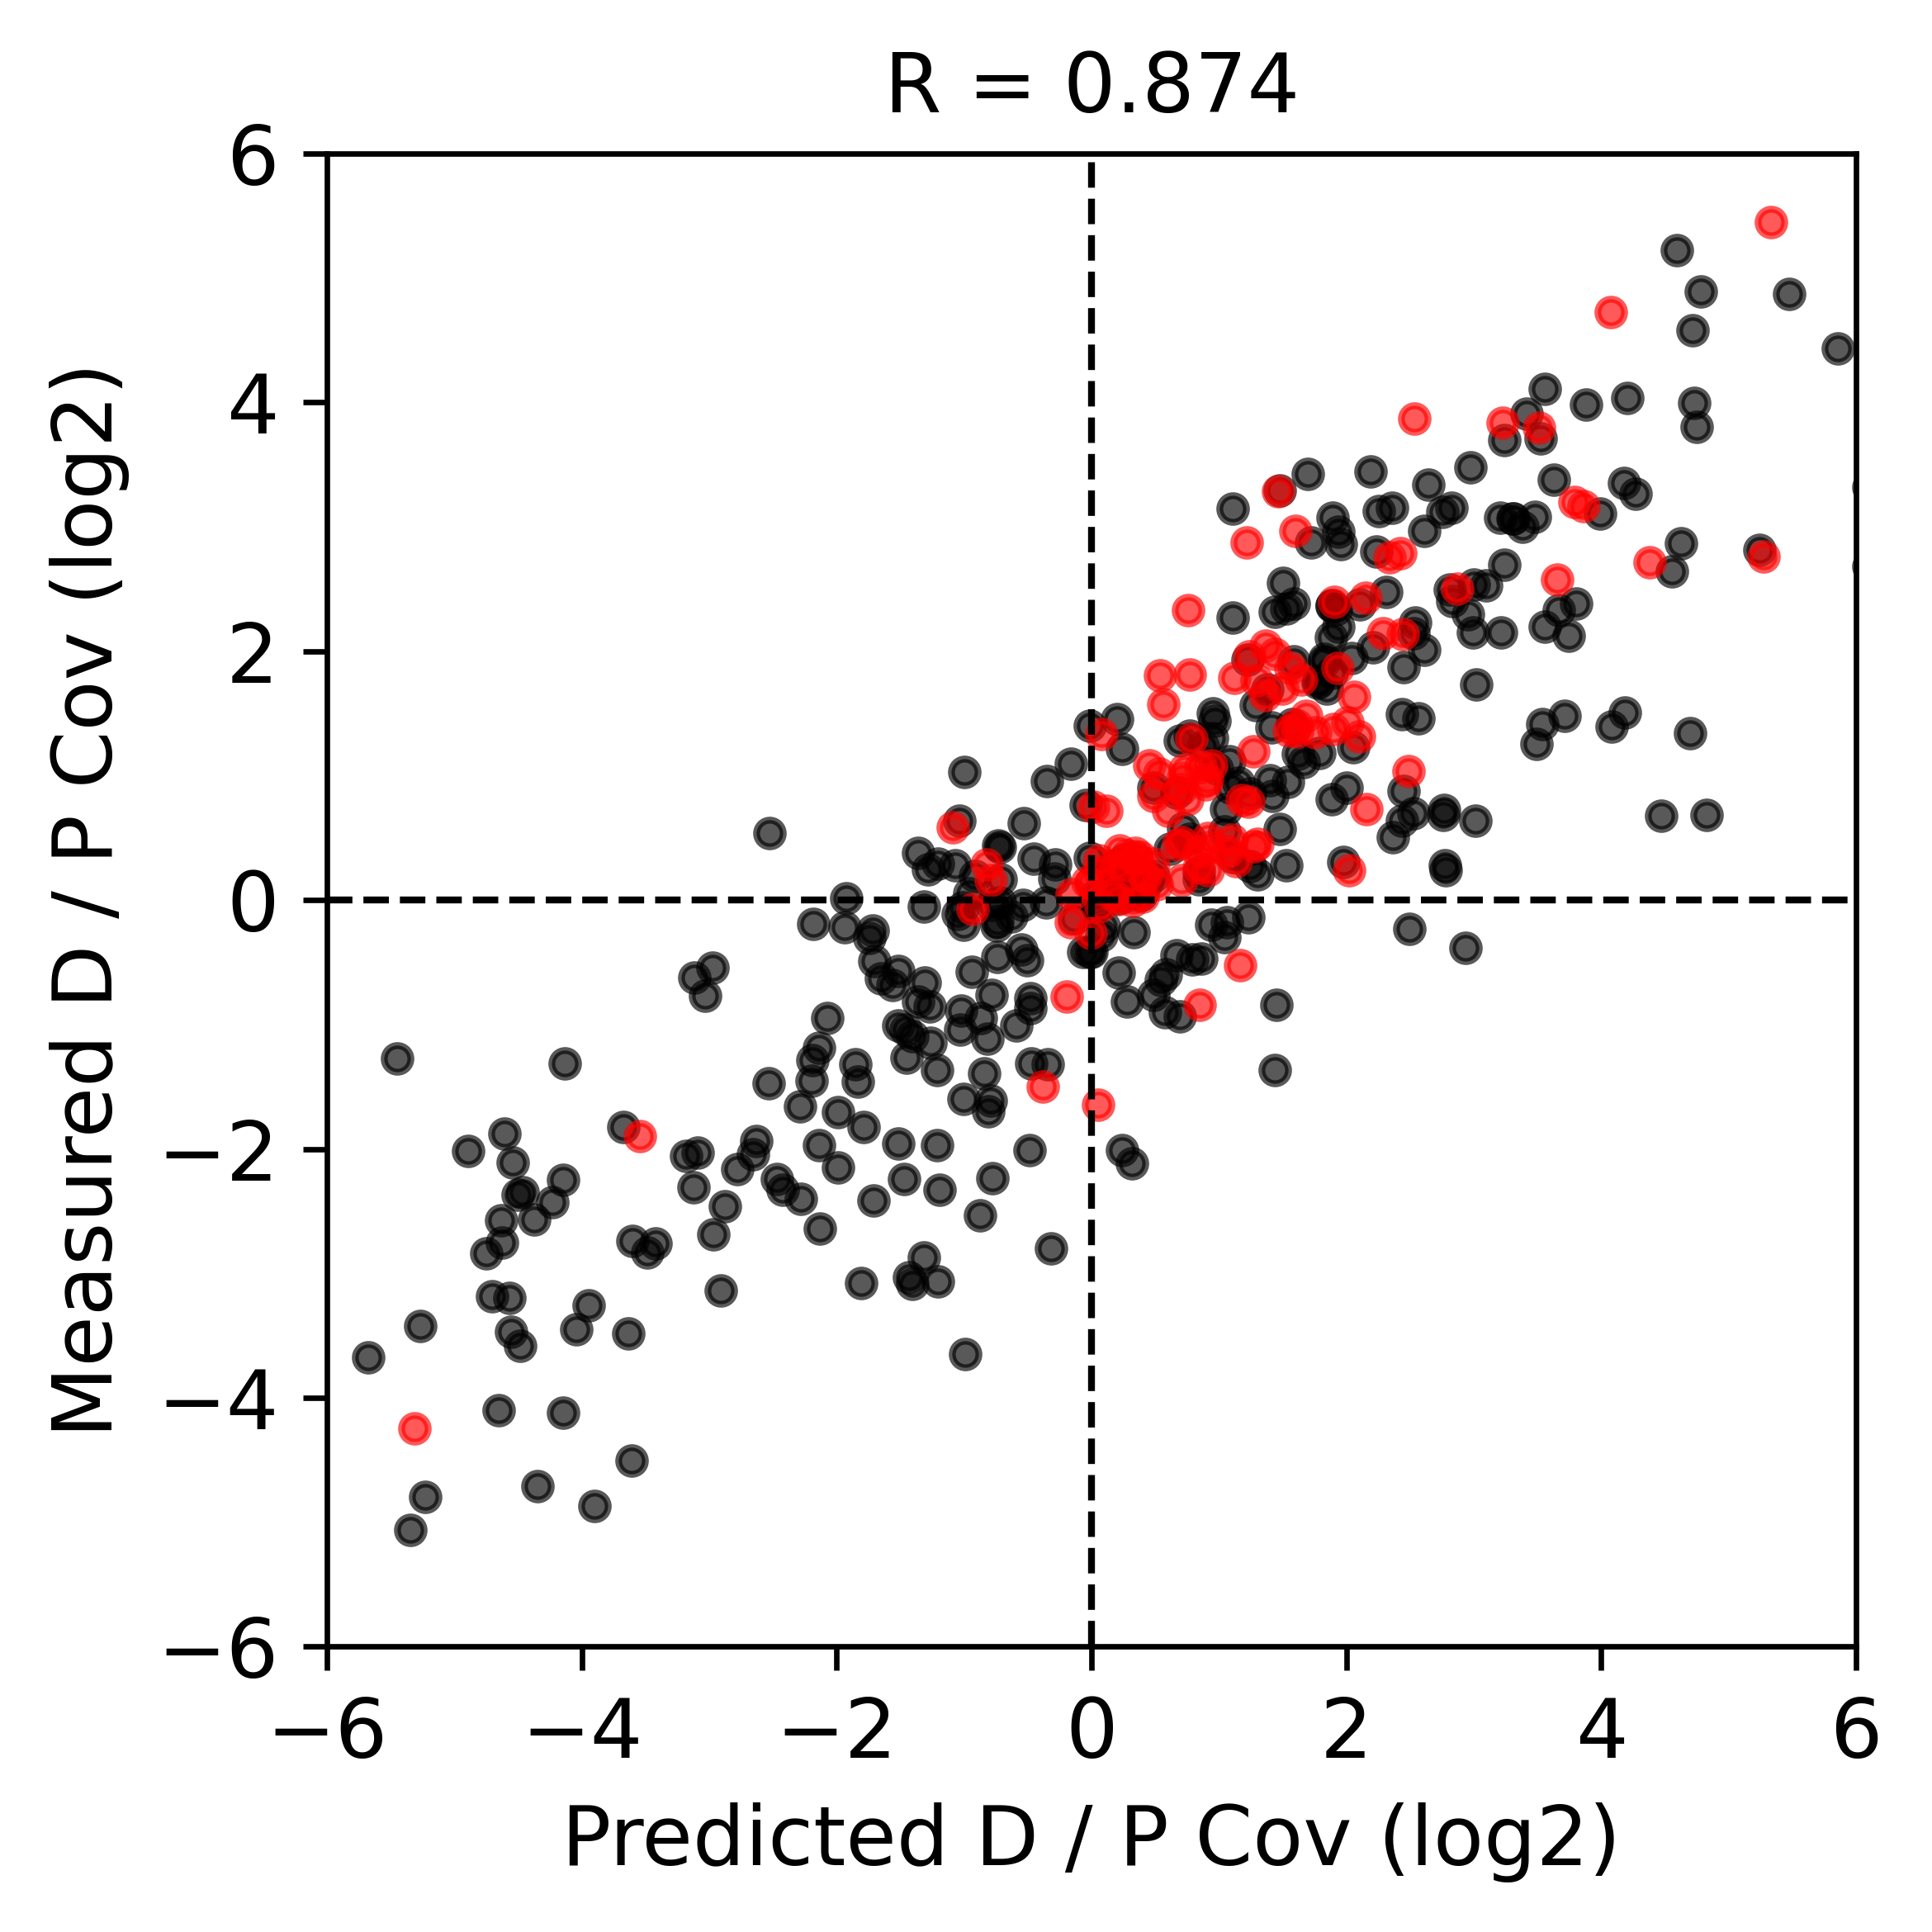

spearman r = 0.676
p = 4.350554199216639e-66
n = 442
(pearson r = 0.699)
spearman r = 0.633
p = 1.645940742424889e-55
n = 442
(pearson r = 0.655)


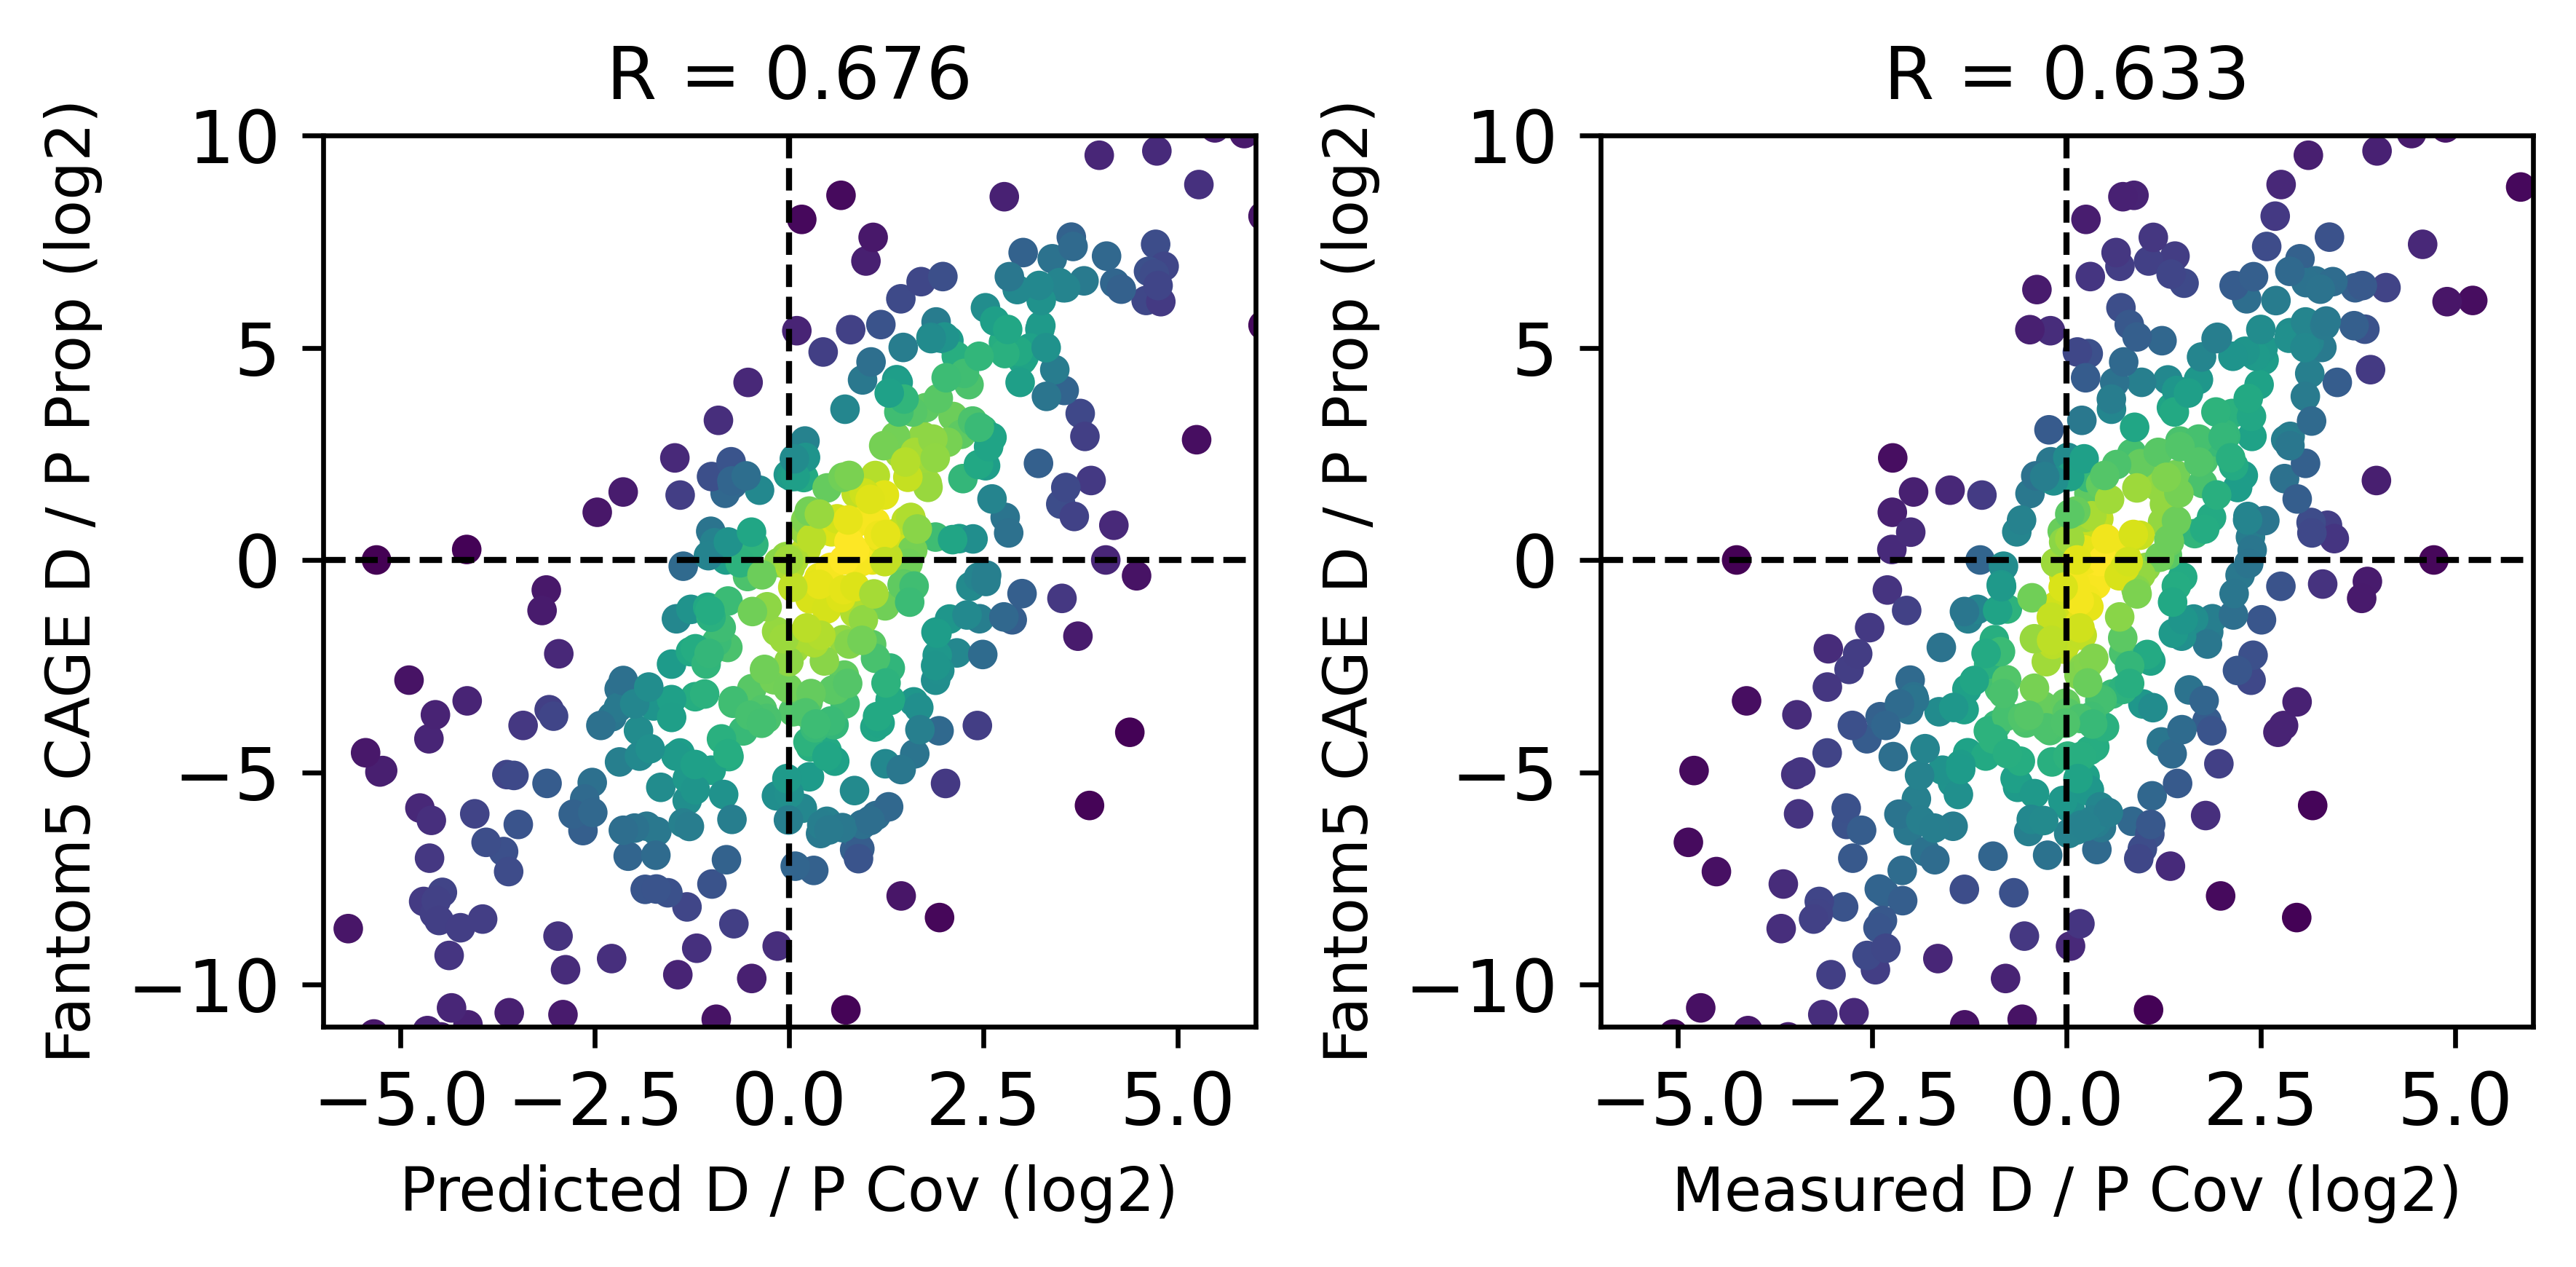

Evaluating for fold = 3
spearman r = 0.827
p = 3.612173395664856e-109
n = 425
(pearson r = 0.83)


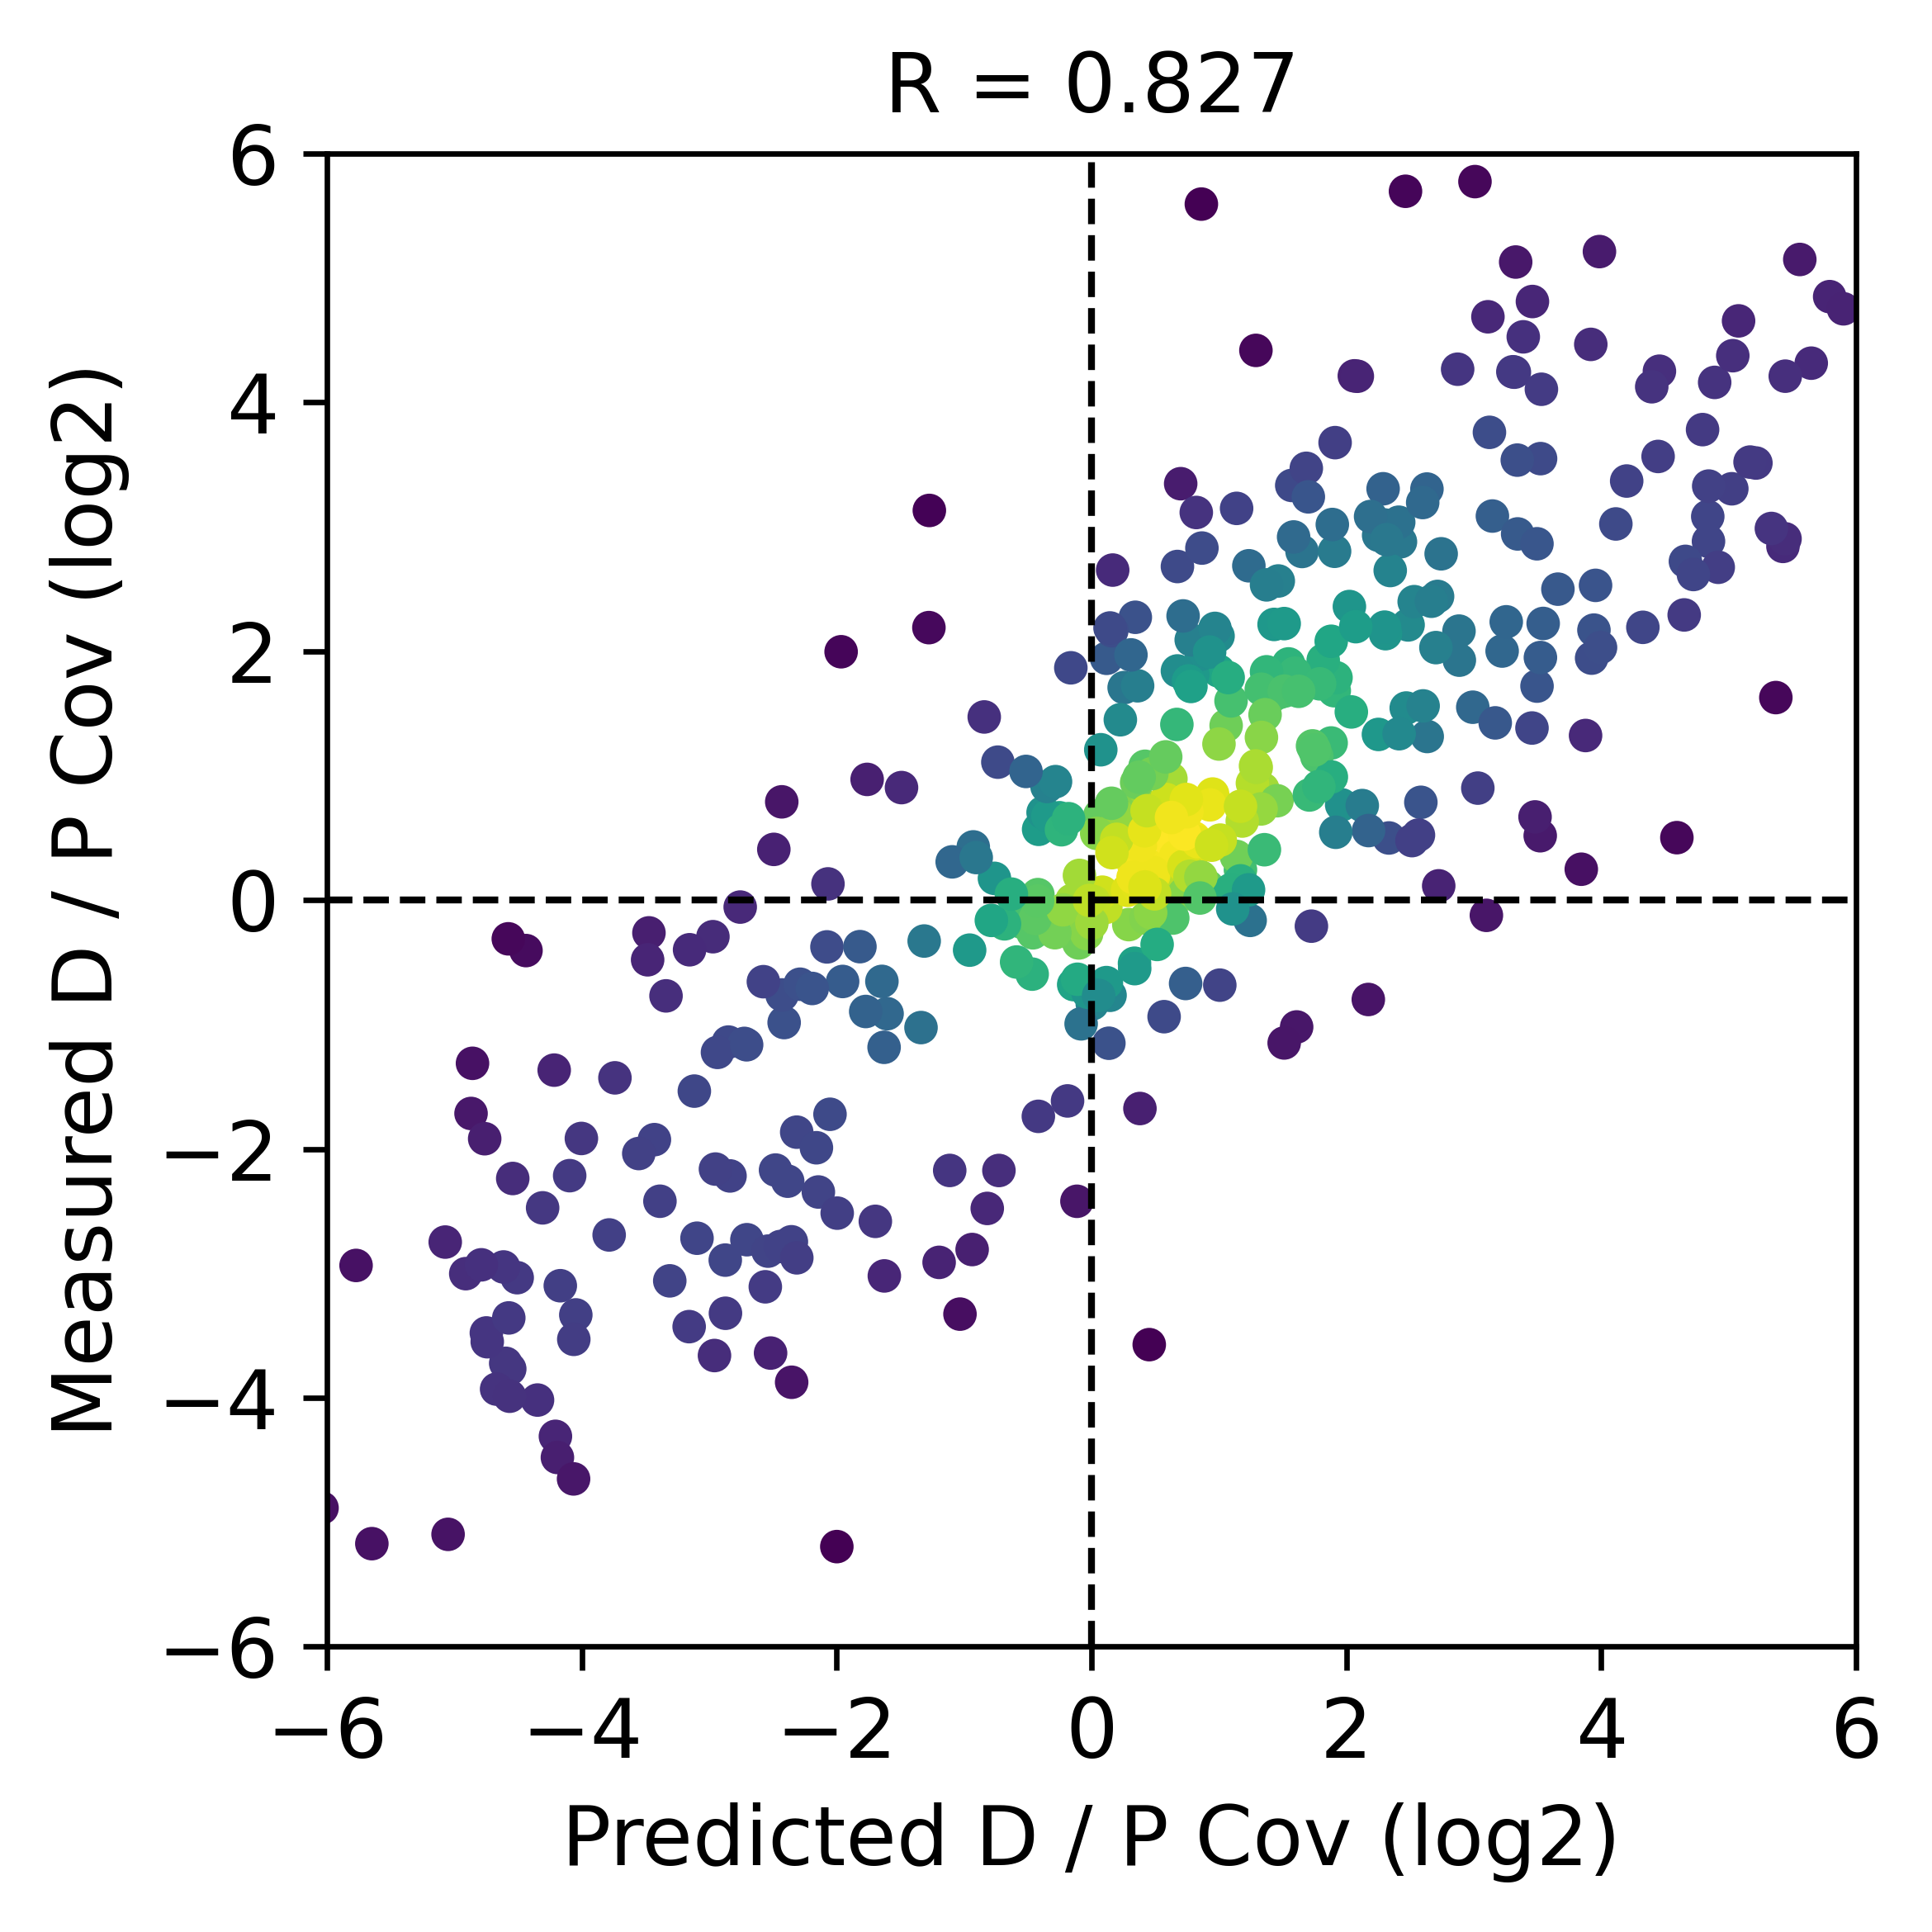

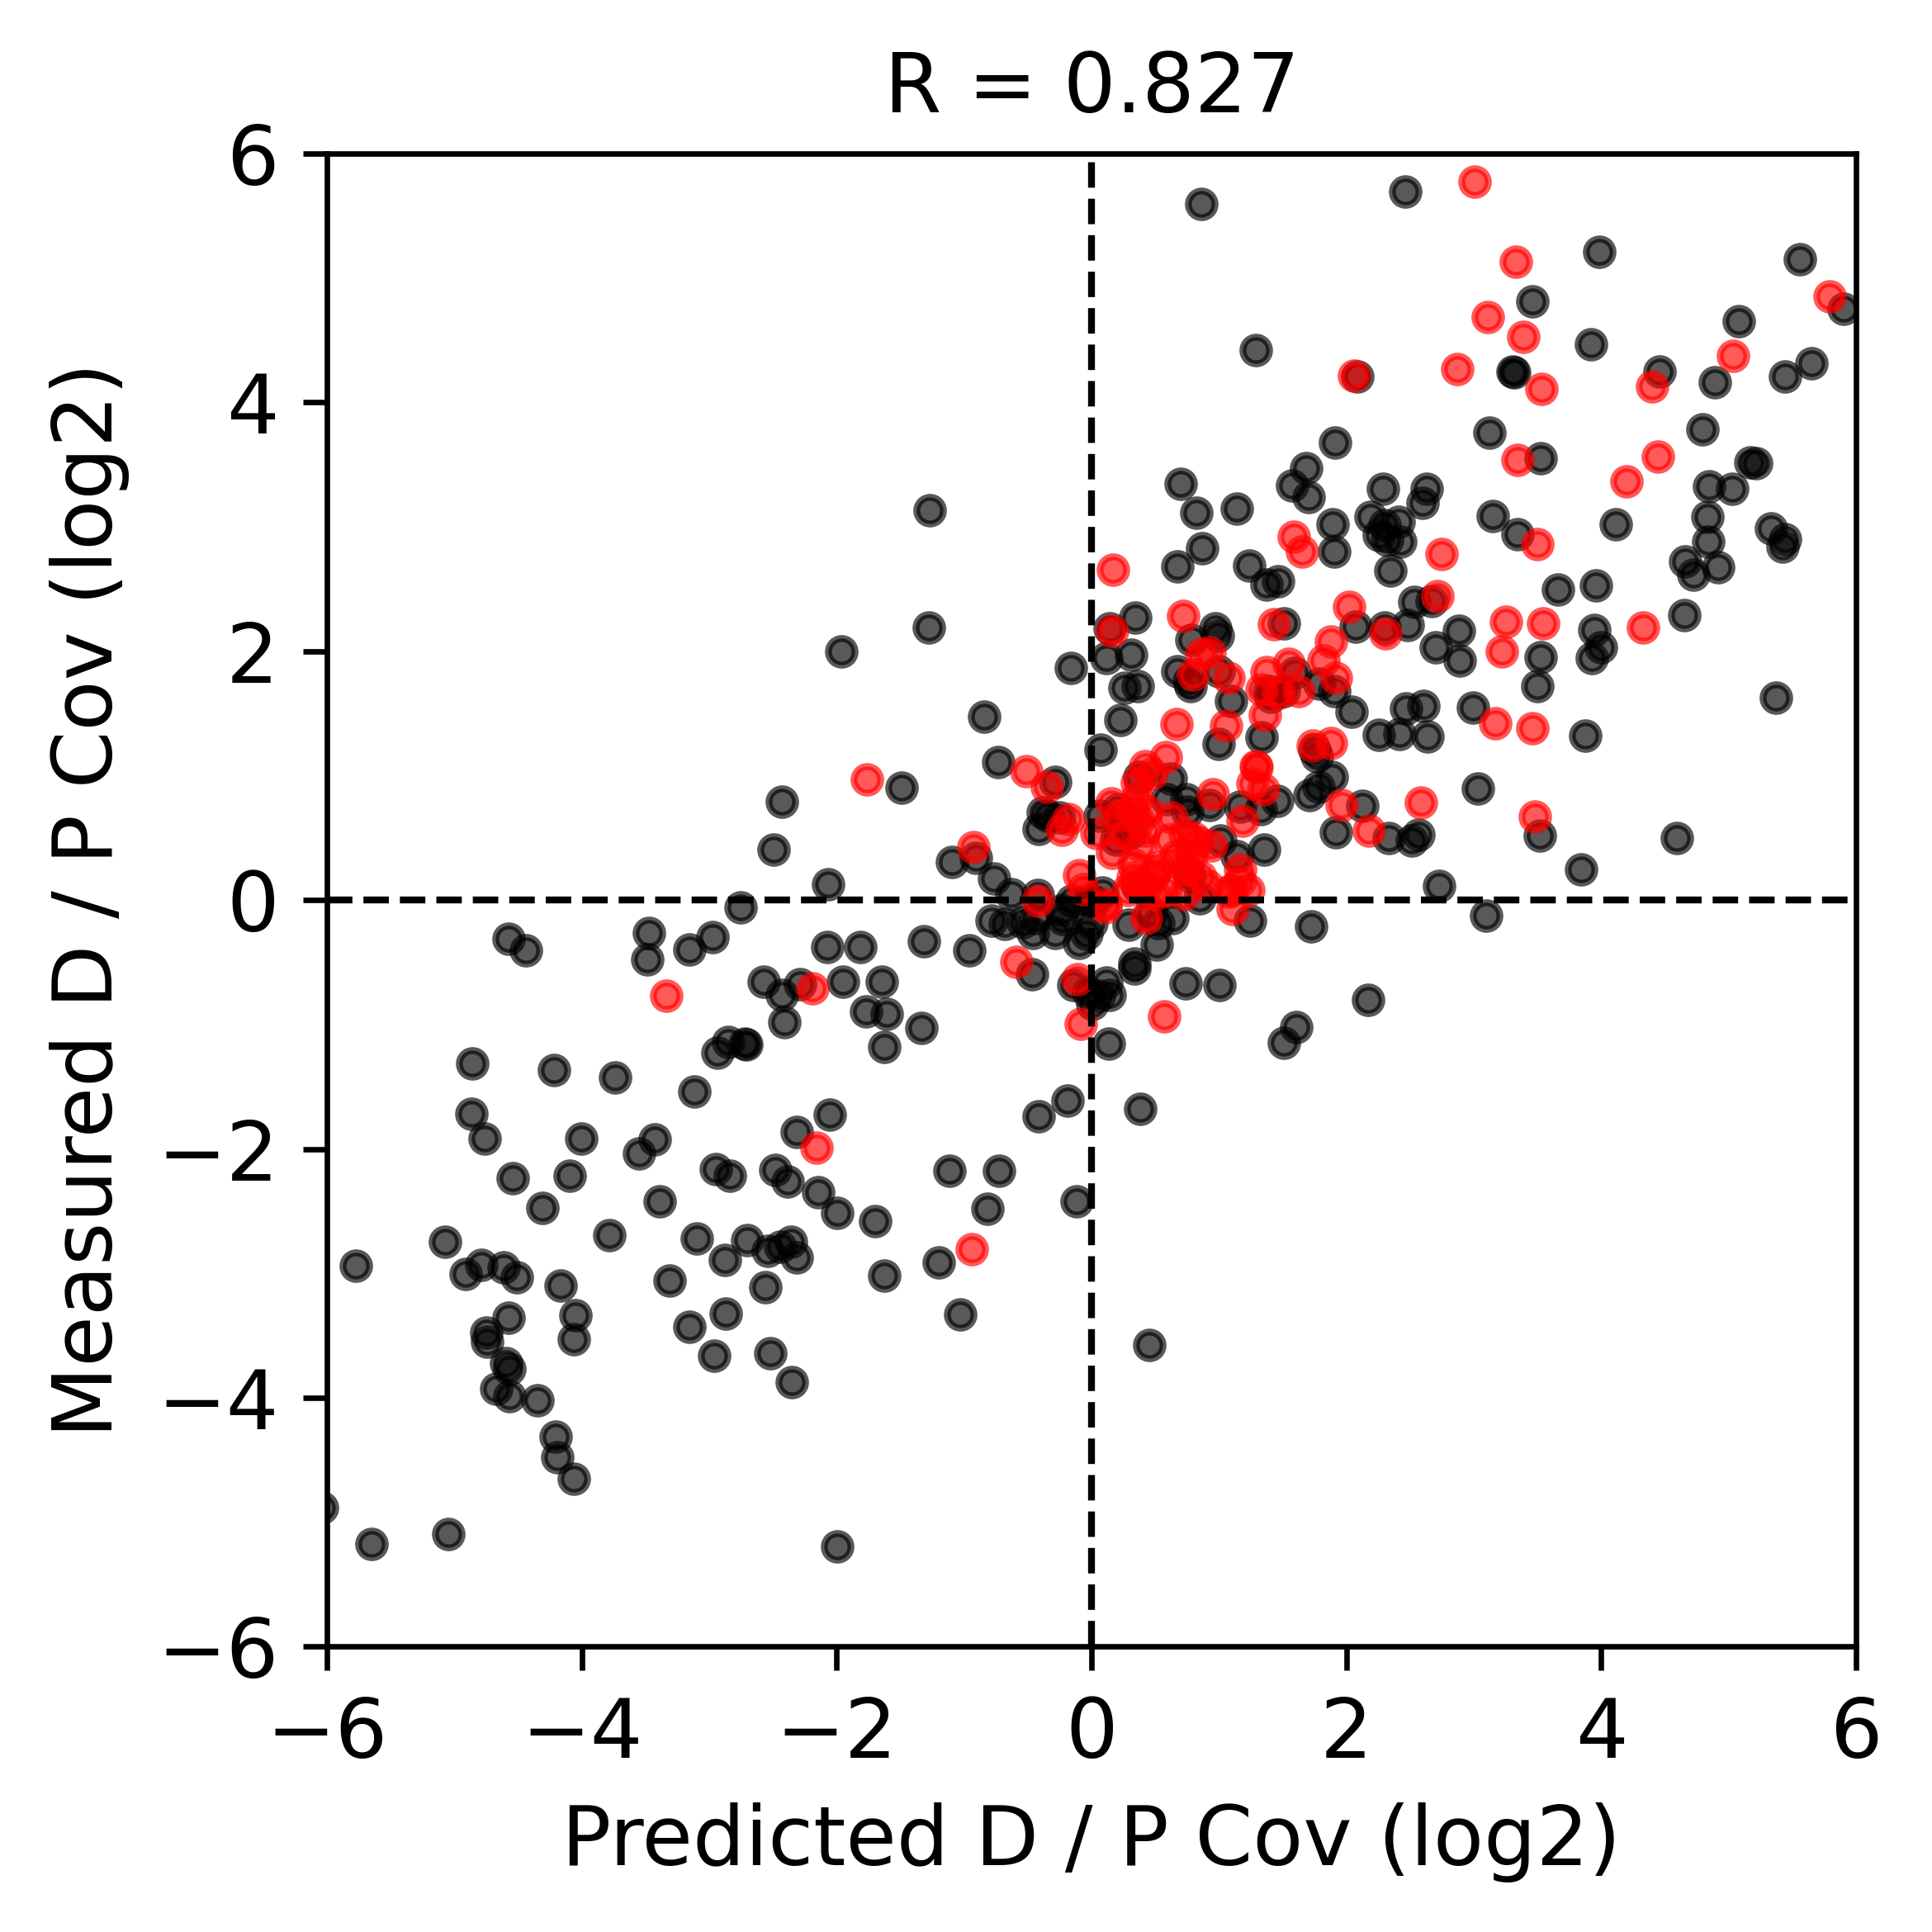

spearman r = 0.596
p = 4.5855483190271e-48
n = 425
(pearson r = 0.628)
spearman r = 0.599
p = 1.735510473029349e-48
n = 425
(pearson r = 0.631)


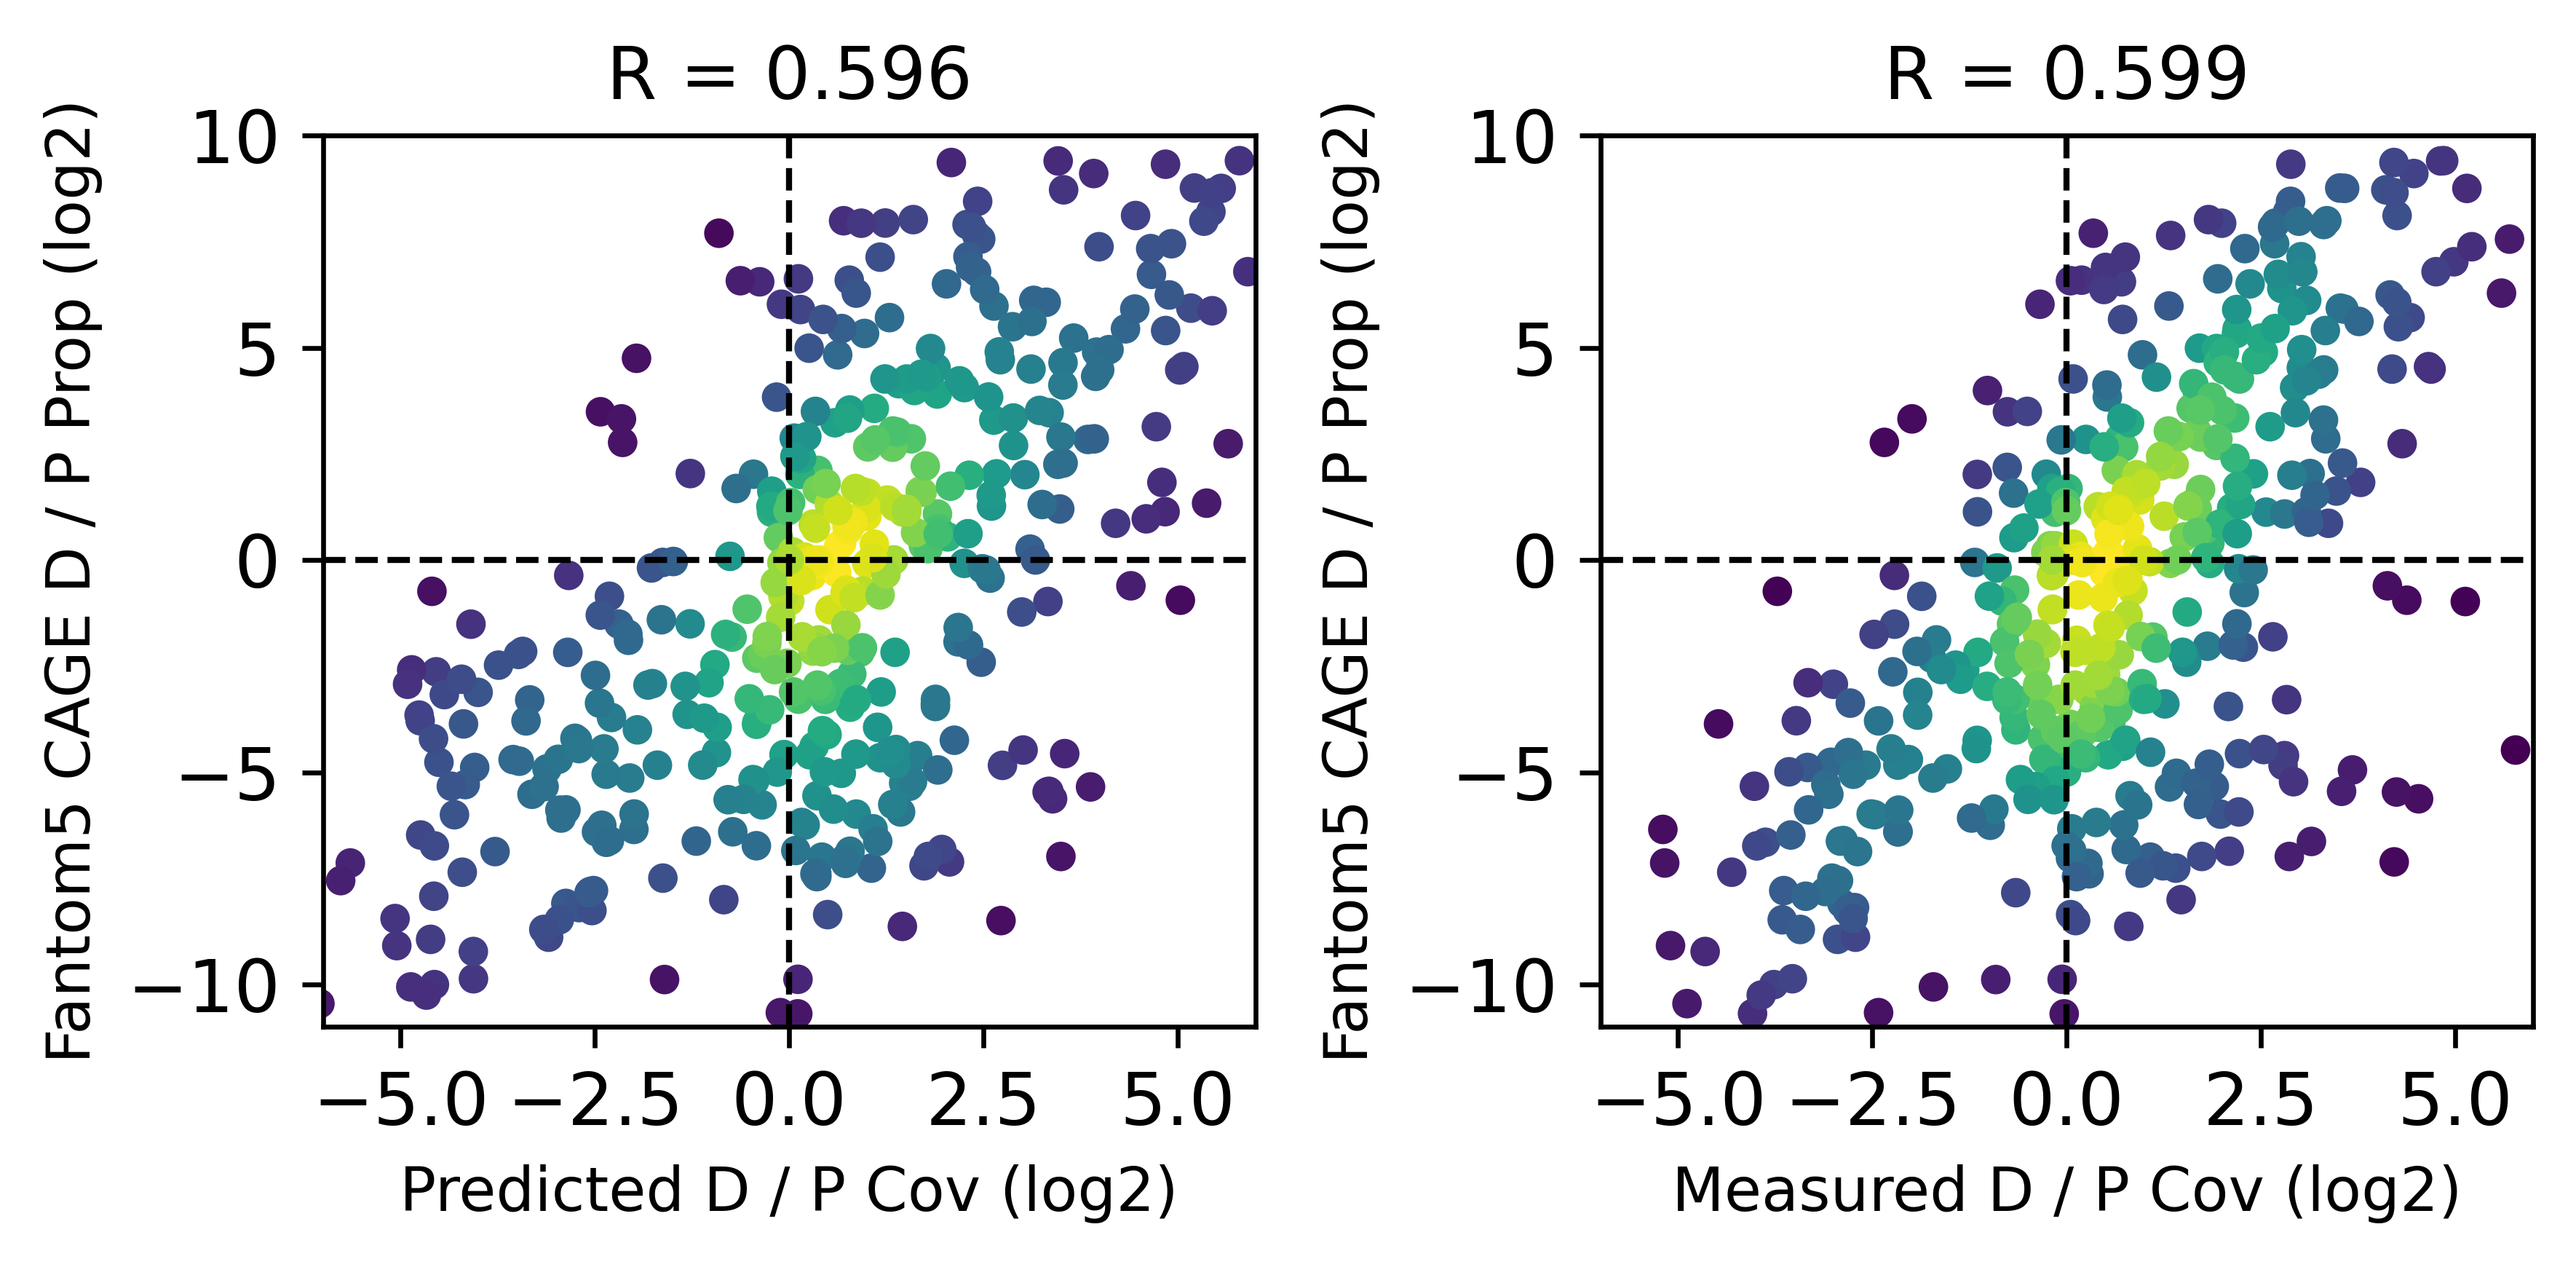

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


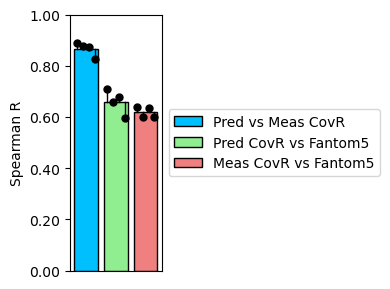

In [8]:
#Evaluate test set performance on held-out genes (tissue-pooled)

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import spearmanr, pearsonr, gaussian_kde

fold_index = [0, 1, 2, 3]

save_figs = True
save_suffix = '_tss_gtex_max'

n_kde_sample = 500

tissue_suffix = ''

rs_mat = np.zeros((3, 4), dtype='float32')

#Loop over folds
for fold_ix in fold_index :
    
    print("Evaluating for fold = " + str(fold_ix))

    test_df = tss_df.loc[(~tss_df['test_fold'].isnull()) & (tss_df['test_fold'] == 'f' + str(fold_ix))].copy().reset_index(drop=True)

    #Re-sort
    test_df['sort_order'] = test_df['tss_start']
    test_df.loc[test_df['strand'] == '-', 'sort_order'] = -test_df.loc[test_df['strand'] == '-']['tss_start']
    test_df = test_df.sort_values(by=['gene', 'sort_order']).copy().reset_index(drop=True)
    
    #Pool predictions / measurements across tissues or cell types
    test_df['cov_pred'] = 0.
    test_df['cov_true'] = 0.
    for tissue in tissues :
        if '_other' not in tissue and (tissue_suffix == '' or tissue_suffix in tissue) :
            test_df['cov_pred'] += test_df[tissue + '_test_pred']
            test_df['cov_true'] += test_df[tissue + '_test_true']
    
    #Aggregate gene-level statistics from TSS dataframe (distal usage proportions, etc.)
    gene_df = test_df.groupby(['gene']).agg({
        'exon_overlap' : ['first', 'last'],
        'antisense_overlap' : ['first', 'last'],
        'strand' : ['first', 'last'],
        'tss_start' : ['first', 'last'],
        'tpm_sum' + ('_' + tissue_suffix if tissue_suffix != '' else '') : ['sum', 'first', 'last'],
        'cov_pred' : ['first', 'last', 'count'],
        'cov_true' : ['first', 'last']
    })

    gene_df.columns = ['_'.join(col).strip() for col in gene_df.columns.values]

    gene_df = gene_df.reset_index().copy()

    gene_df = gene_df.rename(columns={
        'exon_overlap_first' :  'prox_exon_overlap',
        'antisense_overlap_first' :  'prox_antisense_overlap',
        'exon_overlap_last' :  'dist_exon_overlap',
        'antisense_overlap_last' :  'dist_antisense_overlap',
        'strand_first' :  'strand',
        'tss_start_first' : 'prox_tss_start',
        'tss_start_last' : 'dist_tss_start',
        'tpm_sum' + ('_' + tissue_suffix if tissue_suffix != '' else '') + '_sum' : 'total_count',
        'tpm_sum' + ('_' + tissue_suffix if tissue_suffix != '' else '') + '_first' : 'prox_count',
        'tpm_sum' + ('_' + tissue_suffix if tissue_suffix != '' else '') + '_last' : 'dist_count',
        'cov_pred_first' : 'prox_cov_pred',
        'cov_pred_last' : 'dist_cov_pred',
        'cov_true_first' : 'prox_cov_true',
        'cov_true_last' : 'dist_cov_true',
        'cov_pred_count' : 'n_sites',
    })
    
    gene_df = gene_df.query("n_sites > 1").copy().reset_index(drop=True)
    gene_df = gene_df.query("prox_antisense_overlap == False and dist_antisense_overlap == False").copy().reset_index(drop=True)
    gene_df = gene_df.query("prox_exon_overlap == True or dist_exon_overlap == True").copy().reset_index(drop=True)
    gene_df = gene_df.query("(strand == '+' and dist_tss_start - prox_tss_start >= 128) or (strand == '-' and prox_tss_start - dist_tss_start >= 128)").copy().reset_index(drop=True)

    gene_df['cov_ratio_pred'] = gene_df['dist_cov_pred'] / gene_df['prox_cov_pred']
    gene_df['cov_ratio_true'] = gene_df['dist_cov_true'] / gene_df['prox_cov_true']
    gene_df['dist_ratio'] = gene_df['dist_count'] / gene_df['prox_count']
    
    gene_df = gene_df.loc[~(np.isnan(gene_df['cov_ratio_pred']) | np.isinf(gene_df['cov_ratio_pred']))].copy().reset_index(drop=True)
    gene_df = gene_df.loc[~(np.isnan(gene_df['cov_ratio_true']) | np.isinf(gene_df['cov_ratio_true']))].copy().reset_index(drop=True)
    gene_df = gene_df.loc[~(np.isnan(gene_df['dist_ratio']) | np.isinf(gene_df['dist_ratio']))].copy().reset_index(drop=True)

    #Compare predicted vs. measured Distal / Proximal coverage ratios (derived from RNA-seq tracks)
    
    cov_pred = np.log2(gene_df['cov_ratio_pred'].values + 1e-6)
    cov_true = np.log2(gene_df['cov_ratio_true'].values + 1e-6)
    has_exon_overlap = (gene_df['prox_exon_overlap'] & gene_df['dist_exon_overlap']).values
    
    sample_index = np.arange(len(gene_df), dtype='int32')
    np.random.shuffle(sample_index)
    sample_index = sample_index[:n_kde_sample]

    vals = np.concatenate([
        np.copy(cov_pred)[None, :],
        np.copy(cov_true)[None, :],
    ], axis=0)

    gkernel = gaussian_kde(vals[:, sample_index])(vals)

    rs_val, p_val = spearmanr(cov_pred, cov_true)
    rp_val, p_val = pearsonr(cov_pred, cov_true)
    
    rs_mat[0, fold_ix] = rs_val

    print("spearman r = " + str(round(rs_val, 3)))
    print("p = " + str(p_val))
    print("n = " + str(len(gene_df)))
    
    print("(pearson r = " + str(round(rp_val, 3)) + ")")

    #Plot as density KDE
    f = None
    if not save_figs :
        f = plt.figure(figsize=(4, 4))
    else :
        f = plt.figure(figsize=(4, 4), dpi=600)

    plt.scatter(cov_pred, cov_true, s=15, c=gkernel, cmap='viridis', rasterized=True)

    plt.axvline(x=0, color='black', linewidth=1, linestyle='--')
    plt.axhline(y=0, color='black', linewidth=1, linestyle='--')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlim(-6, 6)
    plt.ylim(-6, 6)

    plt.xlabel("Predicted D / P Cov (log2)", fontsize=12)
    plt.ylabel("Measured D / P Cov (log2)", fontsize=12)
    
    plt.title(label="R = " + str(round(rs_val, 3)))

    plt.tight_layout()
    
    if save_figs and fold_ix == 0 :
        plt.savefig('borzoi_v2_cov' + save_suffix + '_fold_' + str(fold_ix) + '_kde.png', dpi=600)
        plt.savefig('borzoi_v2_cov' + save_suffix + '_fold_' + str(fold_ix) + '_kde.pdf')
    
    plt.show()
    
    #Plot with separate color for non-exon-overlapping TSS sites
    f = None
    if not save_figs :
        f = plt.figure(figsize=(4, 4))
    else :
        f = plt.figure(figsize=(4, 4), dpi=600)

    plt.scatter(cov_pred[~has_exon_overlap], cov_true[~has_exon_overlap], alpha=0.65, s=15, c='black', rasterized=True)
    plt.scatter(cov_pred[has_exon_overlap], cov_true[has_exon_overlap], alpha=0.65, s=15, c='red', rasterized=True)

    plt.axvline(x=0, color='black', linewidth=1, linestyle='--')
    plt.axhline(y=0, color='black', linewidth=1, linestyle='--')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlim(-6, 6)
    plt.ylim(-6, 6)

    plt.xlabel("Predicted D / P Cov (log2)", fontsize=12)
    plt.ylabel("Measured D / P Cov (log2)", fontsize=12)
    
    plt.title("R = " + str(round(rs_val, 3)), fontsize=12)

    plt.tight_layout()
    
    if save_figs and fold_ix == 0 :
        plt.savefig('borzoi_v2_cov' + save_suffix + '_fold_' + str(fold_ix) + '_scatter.png', dpi=600)
        plt.savefig('borzoi_v2_cov' + save_suffix + '_fold_' + str(fold_ix) + '_scatter.pdf')
    
    plt.show()
    
    #Compare predicted (or measured) distal / proximal coverage ratio (derived from RNA-seq) against distal / proximal TSS proportions (derived from FANTOM5)

    f, ax = None, None
    if not save_figs :
        f, ax = plt.subplots(1, 2, figsize=(6, 3))
    else :
        f, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=600)

    plt.sca(ax[0])
    
    #Predicted coverage
    cov_pred = np.log2(gene_df['cov_ratio_pred'].values + 1e-6)
    cov_true = np.log2(gene_df['dist_ratio'].values + 1e-6)
    
    vals = np.concatenate([
        np.copy(cov_pred)[None, :],
        np.copy(cov_true)[None, :],
    ], axis=0)

    gkernel = gaussian_kde(vals[:, sample_index])(vals)

    rs_val, p_val = spearmanr(cov_pred, cov_true)
    rp_val, p_val = pearsonr(cov_pred, cov_true)
    
    rs_mat[1, fold_ix] = rs_val

    print("spearman r = " + str(round(rs_val, 3)))
    print("p = " + str(p_val))
    print("n = " + str(len(gene_df)))
    
    print("(pearson r = " + str(round(rp_val, 3)) + ")")

    #Plot as density KDE
    plt.scatter(cov_pred, cov_true, s=15, c=gkernel, cmap='viridis', rasterized=True)

    plt.axvline(x=0, color='black', linewidth=1, linestyle='--')
    plt.axhline(y=0, color='black', linewidth=1, linestyle='--')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlim(-6, 6)
    plt.ylim(-11, 10)

    plt.xlabel("Predicted D / P Cov (log2)", fontsize=10)
    plt.ylabel("Fantom5 CAGE D / P Prop (log2)", fontsize=10)
    
    plt.title("R = " + str(round(rs_val, 3)), fontsize=12)
    
    plt.sca(ax[1])
    
    #Measured coverage
    cov_pred = np.log2(gene_df['cov_ratio_true'].values + 1e-6)
    cov_true = np.log2(gene_df['dist_ratio'].values + 1e-6)
    
    vals = np.concatenate([
        np.copy(cov_pred)[None, :],
        np.copy(cov_true)[None, :],
    ], axis=0)

    gkernel = gaussian_kde(vals[:, sample_index])(vals)

    rs_val, p_val = spearmanr(cov_pred, cov_true)
    rp_val, p_val = pearsonr(cov_pred, cov_true)
    
    rs_mat[2, fold_ix] = rs_val

    print("spearman r = " + str(round(rs_val, 3)))
    print("p = " + str(p_val))
    print("n = " + str(len(gene_df)))
    
    print("(pearson r = " + str(round(rp_val, 3)) + ")")

    #Plot as density KDE
    plt.scatter(cov_pred, cov_true, s=15, c=gkernel, cmap='viridis', rasterized=True)

    plt.axvline(x=0, color='black', linewidth=1, linestyle='--')
    plt.axhline(y=0, color='black', linewidth=1, linestyle='--')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlim(-6, 6)
    plt.ylim(-11, 10)

    plt.xlabel("Measured D / P Cov (log2)", fontsize=10)
    plt.ylabel("Fantom5 CAGE D / P Prop (log2)", fontsize=10)
    
    plt.title("R = " + str(round(rs_val, 3)), fontsize=12)

    plt.tight_layout()
    
    if save_figs and fold_ix == 0 :
        plt.savefig('borzoi_v2_cov' + save_suffix + '_fold_' + str(fold_ix) + '_fantom_kde.png', dpi=600)
        plt.savefig('borzoi_v2_cov' + save_suffix + '_fold_' + str(fold_ix) + '_fantom_kde.pdf')
    
    plt.show()

#Plot performance summary (4-fold CV); with individual fold performance as dots
f = plt.figure(figsize=(4, 3)) #, dpi=300

model_colors = [
    'deepskyblue',
    'lightgreen',
    'lightcoral',
]

model_names = [
    'Pred vs Meas CovR',
    'Pred CovR vs Fantom5',
    'Meas CovR vs Fantom5',
]

for i in range(rs_mat.shape[0]) :
    rs_mean = np.mean(rs_mat[i, :])
    plt.bar([i], rs_mean, width=0.8, edgecolor='black', color=model_colors[i], linewidth=1, zorder=0, label=model_names[i])
    
    for j in range(rs_mat.shape[1]) :
        plt.plot([
            i + (j+1) * (1. / (rs_mat.shape[1] + 1.)) - 0.5,
            i + (j+1) * (1. / (rs_mat.shape[1] + 1.)) - 0.5
        ], [rs_mean, rs_mat[i, j]], linewidth=1, color='black', linestyle='-', zorder=1)
        
        plt.scatter([
            i + (j+1) * (1. / (rs_mat.shape[1] + 1.)) - 0.5
        ], [rs_mat[i, j]], edgecolor='black', linewidth=1, color='black', s=25, zorder=2)

plt.xticks([], [])
plt.yticks(fontsize=10)

plt.ylabel("Spearman R", fontsize=10)

plt.ylim(0, 1)

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

if save_figs :
    plt.savefig('borzoi_v2_cov' + save_suffix + '_bars.png', dpi=600)
    plt.savefig('borzoi_v2_cov' + save_suffix + '_bars.eps')

plt.show()
